# Load Packages and Variables

In [104]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf

from IPython.display import display, HTML
import os

from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = ficc_keras_utils.train_start
train_end = ficc_keras_utils.train_end
test_start = ficc_keras_utils.test_start
test_end = ficc_keras_utils.test_end
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = ficc_keras_utils.NUM_EPOCHS
DROPOUT = ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 2
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys_realtime' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-01-01 2023-03-01 2023-03-01 2023-04-01


# Load Data and Train NN

In [113]:
%time processed_data = load_data_from_pickle('processed_file_FULL_2023-05-03-17:08_5min_12_exp.pkl')

File available, loading pickle
CPU times: user 2min 20s, sys: 39.1 s, total: 2min 59s
Wall time: 3min 57s


In [114]:
processed_data = processed_data[processed_data.trade_date >='2023-01-01']

In [115]:
processed_data.reset_index(drop=True, inplace=True)

In [116]:
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']
processed_data['new_ys_realtime'] = processed_data['yield'] - processed_data['new_real_time_ficc_ycl']

In [117]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col not in PREDICTORS:
        PREDICTORS.append(col)
        NON_CAT_FEATURES.append(col)
        
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes


In [122]:
%%time

processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.16 s


In [123]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

CPU times: user 1.44 s, sys: 31 µs, total: 1.44 s
Wall time: 1.44 s


In [124]:
for col in ['yield_curve_history_5min_12_exponential_0.25', 'yield_curve_history_5min_12_exponential_0.1', 'yield_curve_history_5min_12_exponential_0.5']:
    isnan = processed_data[col].apply(np.sum)
    print(isnan[isnan.isna()].index)
    processed_data = processed_data.drop(isnan[isnan.isna()].index)

Int64Index([43546], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [125]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-02-28 00:00:00
Test data start: 2023-03-01 00:00:00, end: 2023-03-31 00:00:00


In [126]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    for col in yield_history_cols:
        datalist.append(np.stack(df[col].to_numpy()))
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    for i in range(num_yield_history):
        inputs.append(layers.Input(name=f"yield_history_input_{yield_history_cols[i]}", 
                                           shape=(yield_history_lengths[i], 1), 
                                           dtype = tf.float32))
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)

    ####################################################
    
    ############## YIELD HISTORY MODEL #################
    yield_history_outputs = []
    for i in range(num_yield_history):
        yield_lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                                 activation='tanh',
                                 input_shape=(yield_history_lengths[i], 1),
                                 return_sequences = False,
                                 name=f'Yield_History_LSTM_{yield_history_cols[i]}'))

        yield_features = yield_lstm_layer(yield_history_normalizers[i](inputs[i]))
        yield_history_outputs.append(layers.Dense(25, activation='relu')(yield_features))
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate(yield_history_outputs+[reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)
    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(0)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)

    # Normalization layer for the trade history
    trade_history_normalizer = Normalization(name='Trade_history_normalizer')
    trade_history_normalizer.adapt(x_train[num_yield_history],batch_size=BATCH_SIZE)

    # Normalization layer for the non-categorical and binary features
    noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
    noncat_binary_normalizer.adapt(x_train[num_yield_history+2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx

In [127]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [128]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

In [130]:
trade_history_col = 'trade_history_fixed'
yield_history_cols = ['yield_curve_history_5min_12_exponential_0.5']

In [131]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)

TRAINING DATA: N = 1204369, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-02-28 00:00:00
VALIDATION DATA: N = 133818, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-02-28 00:00:00
TEST DATA: N = 708432, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-03-31 00:00:00


2023-05-30 23:32:24.859125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 23:32:24.862771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 23:32:24.866350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 23:32:24.868994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [132]:
results = []
predictions = []

for i in range(1):
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = 0.75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/100


2023-05-30 23:32:58.339306: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-05-30 23:33:09.389282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 321182 of 903276
2023-05-30 23:33:19.389273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 857899 of 903276
2023-05-30 23:3

1177/1177 [==============================] - ETA: 0s - loss: 53.2477 - mean_absolute_error: 53.2477

2023-05-30 23:33:59.966270: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254800896 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1177/1177 [==============================] - 75s 33ms/step - loss: 53.2477 - mean_absolute_error: 53.2477 - val_loss: 48.7863 - val_mean_absolute_error: 48.7863
Epoch 2/100
1177/1177 [==============================] - 25s 21ms/step - loss: 46.8268 - mean_absolute_error: 46.8268 - val_loss: 42.3317 - val_mean_absolute_error: 42.3317
Epoch 3/100
1177/1177 [==============================] - 23s 19ms/step - loss: 36.7363 - mean_absolute_error: 36.7363 - val_loss: 31.2255 - val_mean_absolute_error: 31.2255
Epoch 4/100
1177/1177 [==============================] - 27s 23ms/step - loss: 23.9206 - mean_absolute_error: 23.9206 - val_loss: 15.5405 - val_mean_absolute_error: 15.5405
Epoch 5/100
1177/1177 [==============================] - 24s 20ms/step - loss: 14.0986 - mean_absolute_error: 14.0986 - val_loss: 10.4765 - val_mean_absolute_error: 10.4765
Epoch 6/100
1177/1177 [==============================] - 28s 23ms/step - loss: 11.2844 - mean_absolute_error: 11.2844 - val_loss: 9.9421 - val_mean

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1177/1177 [==============================] - 27s 23ms/step - loss: 9.3357 - mean_absolute_error: 9.3357 - val_loss: 8.4971 - val_mean_absolute_error: 8.4971
Epoch 49/100
1177/1177 [==============================] - 22s 19ms/step - loss: 9.3226 - mean_absolute_error: 9.3226 - val_loss: 8.5084 - val_mean_absolute_error: 8.5084
Epoch 50/100
1177/1177 [==============================] - 27s 23ms/step - loss: 9.3149 - mean_absolute_error: 9.3149 - val_loss: 8.4824 - val_mean_absolute_error: 8.4824
Epoch 51/100
1177/1177 [==============================] - 22s 19ms/step - loss: 9.2945 - mean_absolute_error: 9.2945 - val_loss: 8.4516 - val_mean_absolute_error: 8.4516
Epoch 52/100
 193/1177 [===>..........................] - ETA: 18s - loss: 9.5124 - mean_absolute_error: 9.5124

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1177/1177 [==============================] - 22s 19ms/step - loss: 9.2355 - mean_absolute_error: 9.2355 - val_loss: 8.4552 - val_mean_absolute_error: 8.4552
Epoch 57/100
1177/1177 [==============================] - 22s 19ms/step - loss: 9.2184 - mean_absolute_error: 9.2184 - val_loss: 8.4065 - val_mean_absolute_error: 8.4065
Epoch 58/100
1177/1177 [==============================] - 27s 23ms/step - loss: 9.2131 - mean_absolute_error: 9.2131 - val_loss: 8.4040 - val_mean_absolute_error: 8.4040
Epoch 59/100
 565/1177 [=============>................] - ETA: 11s - loss: 9.2575 - mean_absolute_error: 9.2575

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1177/1177 [==============================] - 24s 20ms/step - loss: 9.0590 - mean_absolute_error: 9.0590 - val_loss: 8.3683 - val_mean_absolute_error: 8.3683
Epoch 74/100
1177/1177 [==============================] - 22s 19ms/step - loss: 9.0526 - mean_absolute_error: 9.0526 - val_loss: 8.3563 - val_mean_absolute_error: 8.3563
Epoch 75/100
1177/1177 [==============================] - 27s 23ms/step - loss: 9.0325 - mean_absolute_error: 9.0325 - val_loss: 8.3263 - val_mean_absolute_error: 8.3263
Epoch 76/100
1177/1177 [==============================] - 22s 18ms/step - loss: 9.0325 - mean_absolute_error: 9.0325 - val_loss: 8.3322 - val_mean_absolute_error: 8.3322
Epoch 77/100
1177/1177 [==============================] - 25s 21ms/step - loss: 9.0267 - mean_absolute_error: 9.0267 - val_loss: 8.3297 - val_mean_absolute_error: 8.3297
Epoch 78/100
  17/1177 [..............................] - ETA: 1:04 - loss: 9.8867 - mean_absolute_error: 9.8867

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1177/1177 [==============================] - 23s 19ms/step - loss: 8.9783 - mean_absolute_error: 8.9783 - val_loss: 8.2857 - val_mean_absolute_error: 8.2857
Epoch 84/100
1177/1177 [==============================] - 23s 19ms/step - loss: 8.9659 - mean_absolute_error: 8.9659 - val_loss: 8.3114 - val_mean_absolute_error: 8.3114
Epoch 85/100
1177/1177 [==============================] - 28s 23ms/step - loss: 8.9533 - mean_absolute_error: 8.9533 - val_loss: 8.2887 - val_mean_absolute_error: 8.2887
Epoch 86/100
 991/1177 [========================>.....] - ETA: 3s - loss: 8.9605 - mean_absolute_error: 8.9605

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [134]:
for i, prediction in enumerate(predictions):
    print(f'{mean_absolute_error(prediction, y_test)}')

9.334812443277674


In [438]:
model.save('2023-05-23_debiasing_experiments')

2023-05-24 02:17:15.699582: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 2023-05-23_debiasing_experiments/assets


INFO:tensorflow:Assets written to: 2023-05-23_debiasing_experiments/assets


# Estimating Bias and Debiasing: Initial Analysis

In [38]:
from ficc.utils.diff_in_days import *

In [39]:
train_dataframe_rmval = train_dataframe.drop(val_idx)
val_dataframe = train_dataframe.loc[val_idx]

In [135]:
tr_pred = model.predict(x_train)
train_dataframe_rmval['prediction_realtime'] = tr_pred
val_pred = model.predict(x_val)
val_dataframe['prediction_realtime'] = val_pred
ts_pred = model.predict(x_test)
test_dataframe['prediction_realtime'] = ts_pred

In [40]:
tr_pred = model.predict(x_train)
train_dataframe_rmval['prediction'] = tr_pred
val_pred = model.predict(x_val)
val_dataframe['prediction'] = val_pred
ts_pred = model.predict(x_test)
test_dataframe['prediction'] = ts_pred

In [136]:
# train_dataframe_rmval.to_pickle('train_dataframe_rmval_realtime.pkl')
# val_dataframe.to_pickle('val_dataframe_realtime.pkl')
# test_dataframe.to_pickle('test_dataframe_realtime.pkl')

In [ ]:
# %%time

# train_dataframe_rmval = pd.read_pickle('train_dataframe_rmval.pkl')
# val_dataframe = pd.read_pickle('val_dataframe.pkl')
# test_dataframe = pd.read_pickle('test_dataframe.pkl')

In [41]:
print(f'TRAIN MAE: {mean_absolute_error(tr_pred,y_train)}')
print(f'VAL MAE: {mean_absolute_error(val_pred, y_val)}')
print(f'TEST MAE: {mean_absolute_error(ts_pred,y_test)}')

TRAIN MAE: 7.538260408257604
VAL MAE: 8.24824877858934
TEST MAE: 9.337018549849434


In [42]:
train_dataframe_rmval['error'] = tr_pred.flatten() - y_train
val_dataframe['error'] = val_pred.flatten() - y_val
test_dataframe['error'] = ts_pred.flatten() - y_test

In [13]:
def summarize_col(data, name):
    print(f'{name:20}: {np.mean(data):.2f}, SD: {data.std():.2f}, Max: {data.max():.2f}, Min: {data.min():.2f}, 75%: {data.quantile(.75):.2f}, 25%: {data.quantile(.25):.2f}')

def create_hour_col(df):
    #Create hour column that is equal to 0 if before market, 25 if after market and the actual hour if during market 
    from datetime import timedelta
    df['hour'] = df.trade_datetime.dt.hour
    bef_market = df.trade_datetime < df.trade_datetime.dt.normalize() + timedelta(hours=9, minutes=30)
    aft_market = df.trade_datetime > df.trade_datetime.dt.normalize() + timedelta(hours=4, minutes=0)
    df.loc[bef_market,'hour'] = 0
    df.loc[aft_market,'hour'] = 25    

def create_maturity_buckets(df):
    #Create hour column that is equal to 0 if before market, 25 if after market and the actual hour if during market 
    from datetime import timedelta
    df['hour'] = df.trade_datetime.dt.hour
    bef_market = df.trade_datetime < df.trade_datetime.dt.normalize() + timedelta(hours=9, minutes=30)
    aft_market = df.trade_datetime > df.trade_datetime.dt.normalize() + timedelta(hours=4, minutes=0)
    df.loc[bef_market,'hour'] = 0
    df.loc[aft_market,'hour'] = 25      
    df['hour'] = df['hour'].astype('category')
    
    
def filter_large_errors(df, upper, lower):
    return df[(df.error < df.error.quantile(upper)) & (df.error > df.error.quantile(lower))]
    
def debias_constant(pred, truth, bias_correction):
    corrected_pred = pred - bias_correction
    print(f'Original bias: {np.mean(pred-truth):.2f}, Original MAE: {mean_absolute_error(pred, truth):.2f}, Corrected bias: {np.mean(corrected_pred-truth):.2f}, Corrected MAE: {mean_absolute_error(corrected_pred, truth):.2f}')
    


From wikipedia: In statistics, the bias of an estimator (or bias function) is the difference between this estimator's expected value and the true value of the parameter being estimated.

In our case, the assumption is that our model errors should have mean 0. As we see below, the distributions look approximately Gaussian but they are not centered about 0 - the deviation from 0 is the estimated bias. We subtract this bias from the predictions (first across the entire train/val/test sets, then within subgroups). This provides a theoretical estimate of model performance if we have an unbiased estimator. 

In [44]:
summarize_col(train_dataframe_rmval.error, 'TRAIN SET BIAS')
summarize_col(val_dataframe.error, 'VALIDATION SET BIAS')
summarize_col(test_dataframe.error, 'TEST SET BIAS')

TRAIN SET BIAS      : -0.64, SD: 13.58, Max: 288.48, Min: -2788.66, 75%: 3.92, 25%: -5.42
VALIDATION SET BIAS : -0.62, SD: 15.22, Max: 213.01, Min: -2788.65, 75%: 4.36, 25%: -5.91
TEST SET BIAS       : -1.58, SD: 15.05, Max: 253.27, Min: -1066.09, 75%: 4.34, 25%: -7.45


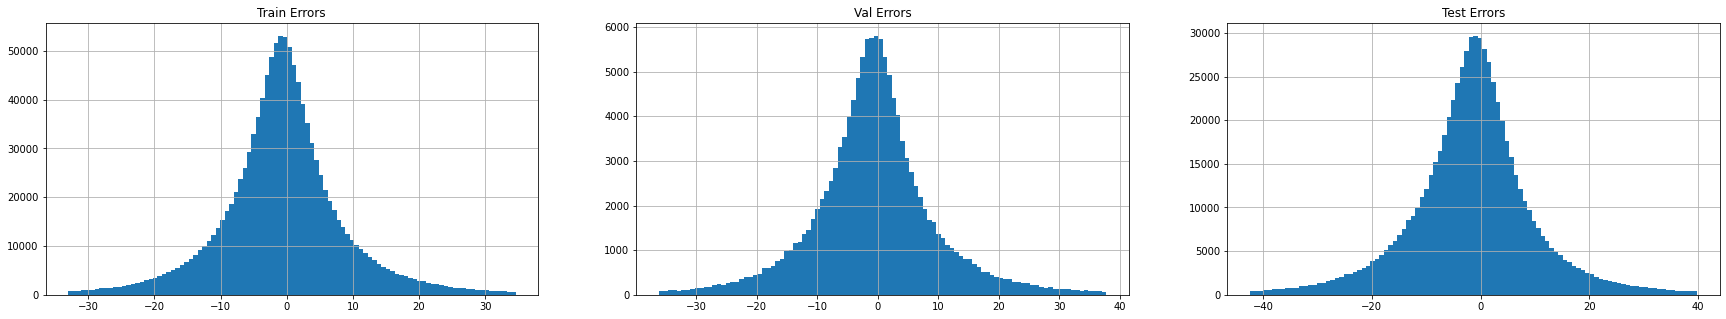

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(30,5))
for i, axes in enumerate(ax):
    if i == 0: 
        filter_large_errors(train_dataframe_rmval, .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Train Errors')
    if i == 1: 
        filter_large_errors(val_dataframe, .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Val Errors')
    if i == 2: 
        filter_large_errors(test_dataframe, .99, .01).error.hist(ax=axes, bins = 100)
        axes.set_title('Test Errors')

There are four calculations below: 

1-3: Debiasing the train/val/test sets using their respective biases 

4: Debiasing the train set using the estimated train set bias

In [46]:
debias_constant(train_dataframe_rmval.prediction, train_dataframe_rmval.new_ys, train_dataframe_rmval.error.mean())
debias_constant(val_dataframe.prediction, val_dataframe.new_ys, val_dataframe.error.mean())
debias_constant(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe.error.mean())
debias_constant(test_dataframe.prediction, test_dataframe.new_ys, train_dataframe_rmval.error.mean())

Original bias: -0.64, Original MAE: 7.54, Corrected bias: -0.00, Corrected MAE: 7.50
Original bias: -0.62, Original MAE: 8.25, Corrected bias: 0.00, Corrected MAE: 8.22
Original bias: -1.58, Original MAE: 9.34, Corrected bias: -0.00, Corrected MAE: 9.25
Original bias: -1.58, Original MAE: 9.34, Corrected bias: -0.94, Corrected MAE: 9.27


## Debiasing within Buckets

We want to experiment with grouping by hour of day so we create a catergorical column for hour. 

We classify all before-market hours under category 0 and all after-market hours as 25.

We also want to groupby maturity in years, so we calculate the difference between calc_date and settlement_date, which we assign to the column calc_duration. 

In [47]:
#create hour column
create_hour_col(train_dataframe_rmval)
create_hour_col(val_dataframe)
create_hour_col(test_dataframe)

#create calc_duration_column
train_dataframe_rmval['calc_duration'] = train_dataframe_rmval[['calc_date','settlement_date']].parallel_apply(lambda x: diff_in_days_two_dates(x['calc_date'], x['settlement_date'])/360, axis=1)
val_dataframe['calc_duration'] = val_dataframe[['calc_date','settlement_date']].parallel_apply(lambda x: diff_in_days_two_dates(x['calc_date'], x['settlement_date'])/360, axis=1)
test_dataframe['calc_duration'] = test_dataframe[['calc_date','settlement_date']].parallel_apply(lambda x: diff_in_days_two_dates(x['calc_date'], x['settlement_date'])/360, axis=1)

In [48]:
bins = list(range(0,31)) + [50] #Buckets are at one year intervals up to 30 years, then everything beyond that in [30-50).
train_dataframe_rmval['duration_bucket'] = pd.cut(train_dataframe_rmval['calc_duration'], bins=bins)
val_dataframe['duration_bucket'] = pd.cut(val_dataframe['calc_duration'], bins=bins)
test_dataframe['duration_bucket'] = pd.cut(test_dataframe['calc_duration'], bins=bins)

We check to make sure that bucket size for calc_duration makes sense:

In [49]:
bucket_summary = pd.DataFrame()
bucket_summary['train'] = train_dataframe_rmval.groupby('duration_bucket').size()
bucket_summary['val'] = val_dataframe.groupby('duration_bucket').size()
bucket_summary['test'] = test_dataframe.groupby('duration_bucket').size()

In [50]:
bucket_summary

,train,val,test
duration_bucket,,,
"(0, 1]",0,0,0
"(1, 2]",124390,13787,76378
"(2, 3]",138067,15297,86405
"(3, 4]",131373,14586,85024
"(4, 5]",119595,13347,71457
"(5, 6]",94314,10523,53577
"(6, 7]",90977,10224,49029
"(7, 8]",78529,8615,40043
"(8, 9]",66629,7413,35859


In [61]:
def groupby_check(df, groupby_cols, small_group_threshold = 50):
    #N=30-50 is the general sample size needed for CLT to apply, hence we set the default for small_group_threshold = 50
    
    for col in groupby_cols:
        if col not in df.columns: 
            raise KeyError(f'Col {col} not in data frame')
            
    temp = train_dataframe_rmval.groupby(groupby_cols).size()
    n_groups = len(temp)
    zero_groups = temp[temp == 0]
    small_groups = temp[temp < 50]
    print(f'Groupby cols: {groupby_cols}\nTotal Groups = {n_groups}\nGroups with zero trades: {len(zero_groups)}({100*len(zero_groups)/n_groups:.2f}%)\nGroups with <{small_group_threshold} groups: {100*len(small_groups)}({100*len(small_groups)/n_groups:.2f}%)')
    
    if len(zero_groups) <= 30:
        display(zero_groups)
    if len(small_groups) <= 30:
        display(small_groups)

More than half the groups have zero observations if we groupby ['trade_date', 'hour', 'duration_bucket'], it isn't ideal to estimate bias within each subgroup.

If we just go by ['trade_date', ''duration_bucket'], most have enough observations. In any case, we try different combinations of columns to see the results.

In [55]:
groupby_date_hour_duration_cols = ['trade_date', 'hour', 'duration_bucket']
groupby_date_duration_cols = ['trade_date', 'duration_bucket']
groupby_hour_duration_cols = ['hour', 'duration_bucket']
groupby_hour_date_cols = ['hour', 'trade_date']

In [62]:
groupby_check(train_dataframe_rmval, groupby_date_hour_duration_cols)

Groupby cols: ['trade_date', 'hour', 'duration_bucket']
Total Groups = 2418
Groups with zero trades: 1228(50.79%)
Groups with <50 groups: 124800(51.61%)


In [63]:
groupby_check(train_dataframe_rmval, ['trade_date', 'duration_bucket'])

Groupby cols: ['trade_date', 'duration_bucket']
Total Groups = 1209
Groups with zero trades: 39(3.23%)
Groups with <50 groups: 3900(3.23%)


In [64]:
def debias_subgroups(df, groupby_cols, target_col = 'new_ys', biases = None):
    #We can either calculate subgroup biases using the same dataframe passed, or pass our own subgroup biases. For example, using subgroup biases from the train set to correct the test set 
    if not biases: biases = df.groupby(groupby_cols)['error'].mean().fillna(0).to_dict()
    corrected_pred = df.groupby(groupby_cols)['prediction'].apply(lambda x: x - biases[x.name])
    
    pred = df['prediction']
    truth = df[target_col]
    
    print(f'Original total bias: {np.mean(pred-truth):.2f}, Original MAE: {mean_absolute_error(pred, truth):.2f}')
    print(f'MAE under bias correction using overall bias: {mean_absolute_error(pred-np.mean(pred-truth), truth):.2f}')
    print(f'MAE under bias correction using subgroup biases: {mean_absolute_error(corrected_pred, truth):.2f}')
    print(f'Largest Bias: {max(biases.values()):.2f}, Group: {max(zip(biases.values(), biases.keys()))[1]}')
    print(f'Smallest Bias: {min(biases.values()):.2f}, Group: {min(zip(biases.values(), biases.keys()))[1]}')
    print(f'Average Subgroup Bias: {np.mean(list(biases.values())):.2f}')
    print()

### Analysis:

A perfectly unbiased model produces out-of-sample performance of 9.02 MAE (compared to 9.36) whether or not we groupby ['trade_date', 'hour', 'duration_bucket'] or ['trade_date', 'duration_bucket']. It would appear that the added granularity of 'hour' does not help, which suggests that idiosyncrasies in the true underlying distribution of yield spreads exist within-day rather than within-day and within-hour.  However, it is important to note that this cannot be used in production, since we cannot estimate bias on trade_dates in the training set and have those carried over to the test set. 

This reduction in MAE by 0.34 is purely hypothetical, and it tells us how the model could perform if we had both unbiased yield predictions and yield curve estimates. It is also worth noting that the labels being used currently are still based on daily yield spreads, since there was no obvious gain from calculating new_ys using realtime yields.

If we instead estimate biases using ['trade_date', 'duration_bucket'] in the train set to correct the test set, MAE falls by a much more modest 9.36 to 9.31. It is not clear if this is noise related or not.

In [65]:
print(groupby_date_hour_duration_cols)
debias_subgroups(train_dataframe_rmval, groupby_date_hour_duration_cols)
debias_subgroups(val_dataframe, groupby_date_hour_duration_cols)
debias_subgroups(test_dataframe, groupby_date_hour_duration_cols)

['trade_date', 'hour', 'duration_bucket']
Original total bias: -0.64, Original MAE: 7.54
MAE under bias correction using overall bias: 7.50
MAE under bias correction using subgroup biases: 7.43
Largest Bias: 15.19, Group: (Timestamp('2023-01-24 00:00:00'), 0, Interval(9, 10, closed='right'))
Smallest Bias: -24.91, Group: (Timestamp('2023-02-06 00:00:00'), 25, Interval(26, 27, closed='right'))
Average Subgroup Bias: -0.27

Original total bias: -0.62, Original MAE: 8.25
MAE under bias correction using overall bias: 8.22
MAE under bias correction using subgroup biases: 8.15
Largest Bias: 8.50, Group: (Timestamp('2023-02-07 00:00:00'), 0, Interval(16, 17, closed='right'))
Smallest Bias: -74.59, Group: (Timestamp('2023-02-06 00:00:00'), 25, Interval(26, 27, closed='right'))
Average Subgroup Bias: -0.28

Original total bias: -1.58, Original MAE: 9.34
MAE under bias correction using overall bias: 9.25
MAE under bias correction using subgroup biases: 8.97
Largest Bias: 23.54, Group: (Timestamp

In [66]:
print(groupby_date_duration_cols)
debias_subgroups(train_dataframe_rmval, groupby_date_duration_cols)
debias_subgroups(val_dataframe, groupby_date_duration_cols)
debias_subgroups(test_dataframe, groupby_date_duration_cols)

['trade_date', 'duration_bucket']
Original total bias: -0.64, Original MAE: 7.54
MAE under bias correction using overall bias: 7.50
MAE under bias correction using subgroup biases: 7.43
Largest Bias: 3.85, Group: (Timestamp('2023-01-24 00:00:00'), Interval(20, 21, closed='right'))
Smallest Bias: -24.91, Group: (Timestamp('2023-02-06 00:00:00'), Interval(26, 27, closed='right'))
Average Subgroup Bias: -0.52

Original total bias: -0.62, Original MAE: 8.25
MAE under bias correction using overall bias: 8.22
MAE under bias correction using subgroup biases: 8.15
Largest Bias: 6.87, Group: (Timestamp('2023-01-19 00:00:00'), Interval(19, 20, closed='right'))
Smallest Bias: -74.59, Group: (Timestamp('2023-02-06 00:00:00'), Interval(26, 27, closed='right'))
Average Subgroup Bias: -0.54

Original total bias: -1.58, Original MAE: 9.34
MAE under bias correction using overall bias: 9.25
MAE under bias correction using subgroup biases: 8.97
Largest Bias: 7.23, Group: (Timestamp('2023-03-14 00:00:00')

In [67]:
print(groupby_hour_duration_cols)
debias_subgroups(train_dataframe_rmval, groupby_hour_duration_cols)
debias_subgroups(val_dataframe, groupby_hour_duration_cols)
debias_subgroups(test_dataframe, groupby_hour_duration_cols)

['hour', 'duration_bucket']
Original total bias: -0.64, Original MAE: 7.54
MAE under bias correction using overall bias: 7.50
MAE under bias correction using subgroup biases: 7.50
Largest Bias: 9.51, Group: (0, Interval(9, 10, closed='right'))
Smallest Bias: -14.29, Group: (0, Interval(15, 16, closed='right'))
Average Subgroup Bias: -0.79

Original total bias: -0.62, Original MAE: 8.25
MAE under bias correction using overall bias: 8.22
MAE under bias correction using subgroup biases: 8.22
Largest Bias: 8.50, Group: (0, Interval(16, 17, closed='right'))
Smallest Bias: -14.23, Group: (0, Interval(8, 9, closed='right'))
Average Subgroup Bias: -0.68

Original total bias: -1.58, Original MAE: 9.34
MAE under bias correction using overall bias: 9.25
MAE under bias correction using subgroup biases: 9.24
Largest Bias: 23.54, Group: (0, Interval(13, 14, closed='right'))
Smallest Bias: -9.63, Group: (0, Interval(24, 25, closed='right'))
Average Subgroup Bias: -0.37



In [68]:
debias_subgroups(test_dataframe, 
                 groupby_hour_duration_cols, 
                 biases = train_dataframe_rmval.groupby(groupby_hour_duration_cols)['error'].mean().fillna(0).to_dict())

Original total bias: -1.58, Original MAE: 9.34
MAE under bias correction using overall bias: 9.25
MAE under bias correction using subgroup biases: 9.28
Largest Bias: 9.51, Group: (0, Interval(9, 10, closed='right'))
Smallest Bias: -14.29, Group: (0, Interval(15, 16, closed='right'))
Average Subgroup Bias: -0.79



## Investigating Biases Further: Autocorrelated?

Some initial research shows that there does indeed exist autocorrelation in the data, and we can indeed predict the bias in the test set using a simple AR(2) or AR(3) linear model to a better degree of accuracy than using the naive estimate of taking the previous value. We return to this later.

In [96]:
import statsmodels.api as sm

In [94]:
def bias_autcorr(data, label):
    print(f'Overall {label} set bias autocorrelation: {data.autocorr():.2f}, first-differenced autocorrelation: {data.diff().autocorr():.2f}, second-differenced autocorrelation: {data.diff().autocorr():.2f}')

By Trade Date:

In [95]:
bias_autcorr(train_dataframe_rmval.groupby('trade_date')['error'].mean(), 'train')
bias_autcorr(val_dataframe.groupby('trade_date')['error'].mean(), 'val')
bias_autcorr(test_dataframe.groupby('trade_date')['error'].mean(), 'test')

Overall train set bias autocorrelation: 0.16, first-differenced autocorrelation: -0.40, second-differenced autocorrelation: -0.40
Overall val set bias autocorrelation: 0.13, first-differenced autocorrelation: -0.44, second-differenced autocorrelation: -0.44
Overall test set bias autocorrelation: 0.07, first-differenced autocorrelation: -0.41, second-differenced autocorrelation: -0.41


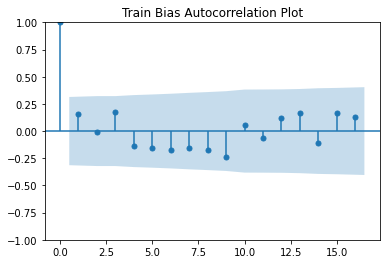

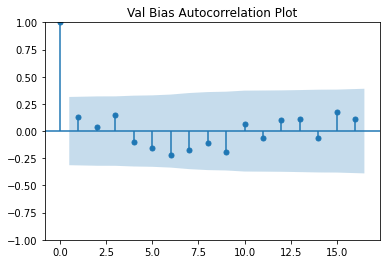

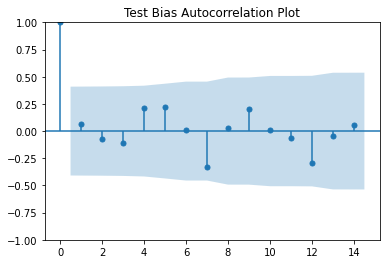

In [106]:
sm.graphics.tsa.plot_acf(train_dataframe_rmval.groupby('trade_date')['error'].mean(), title='Train Bias Autocorrelation Plot');
sm.graphics.tsa.plot_acf(val_dataframe.groupby('trade_date')['error'].mean(), title='Val Bias Autocorrelation Plot');
sm.graphics.tsa.plot_acf(test_dataframe.groupby('trade_date')['error'].mean(), title='Test Bias Autocorrelation Plot');

In [158]:
def create_autocorr_df(data, lags = 5):
    df = pd.DataFrame()
    for i in range(lags+1): 
        df[f'Lag_{i}'] = data.shift(i)
    return df.rename({'Lag_0':'target'}, axis=1)

In [173]:
acr_df = create_autocorr_df(pd.concat([train_dataframe_rmval.groupby('trade_date')['error'].mean(), test_dataframe.groupby('trade_date')['error'].mean()]), lags = 5)
train_acr_df = acr_df.loc[:train_end].iloc[:-1] #includes 2023-03-01 so we drop the last row
test_acr_df = acr_df.loc[test_start:]

In [182]:
def run_AR_model(lags = 2, diff = 0):
    print(f'AR({lags}) Model, difference of order {diff}')
    lag_cols =[f'Lag_{i}' for i in range(1,lags+1)]
    train_data = train_acr_df[lag_cols+['target']]
    test_data = test_acr_df[lag_cols+['target']]
    if diff:
        train_data = train_data.diff(diff)
        test_data = test_data.diff(diff)
        
    train_data = train_data.dropna()
    test_data = test_data.dropna()
        
    X_train = sm.add_constant(train_data.drop('target',axis=1))
    y_train = train_data['target']
    X_test = sm.add_constant(test_data.drop('target',axis=1))
    y_test = test_data['target']

    lm = sm.OLS(y_train, X_train).fit()
    pred_test = lm.predict(X_test)
    pred_train = lm.predict(X_train)

    print(f'TRAIN MAE: {mean_absolute_error(pred_train, y_train):.2f}')
    print(f'TEST MAE: {mean_absolute_error(pred_test, y_test):.2f}')
    print()

In [190]:
print(F'Benchmark MAE using Previous Value as Naive Estimate: TRAIN: {mean_absolute_error(train_acr_df.dropna().target, train_acr_df.dropna().Lag_1):.2F}, Test: {mean_absolute_error(test_acr_df.target, test_acr_df.Lag_1):.2F}\n')

for i in range(5):
    for j in range(2):
        run_AR_model(i,j)

Benchmark MAE using Previous Value as Naive Estimate: TRAIN: 1.30, Test: 2.41

AR(0) Model, difference of order 0
TRAIN MAE: 0.90
TEST MAE: 2.00

AR(0) Model, difference of order 1
TRAIN MAE: 1.23
TEST MAE: 2.44

AR(1) Model, difference of order 0
TRAIN MAE: 0.88
TEST MAE: 1.98

AR(1) Model, difference of order 1
TRAIN MAE: 1.08
TEST MAE: 2.27

AR(2) Model, difference of order 0
TRAIN MAE: 0.90
TEST MAE: 1.97

AR(2) Model, difference of order 1
TRAIN MAE: 0.92
TEST MAE: 2.13

AR(3) Model, difference of order 0
TRAIN MAE: 0.88
TEST MAE: 1.96

AR(3) Model, difference of order 1
TRAIN MAE: 0.92
TEST MAE: 2.15

AR(4) Model, difference of order 0
TRAIN MAE: 0.84
TEST MAE: 2.12

AR(4) Model, difference of order 1
TRAIN MAE: 0.91
TEST MAE: 2.08



# Adding first_published

We add the 'first_published_datetime' column to the test dataframe so that we can simulate production where we do not have trades in the last 60 seconds of a given trade. 

In [39]:
from ficc.utils.auxiliary_functions import sqltodf

In [40]:
published_datetime_df = sqltodf('''SELECT rtrs_control_number, 
first_published_datetime,
FROM
`eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '2023-01-01'
  AND trade_date <= '2023-05-01'
  AND coupon_type in (8, 4, 10, 17)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
  AND settlement_date is not null
  ORDER BY trade_datetime desc''', bq_client)

In [46]:
test_dataframe = pd.merge(test_dataframe, published_datetime_df, on='rtrs_control_number')

# Simulating Debiasing in Production:

In [9]:
# %%time

# train_dataframe_rmval = pd.read_pickle('train_dataframe_rmval_realtime.pkl')
# val_dataframe = pd.read_pickle('val_dataframe_realtime.pkl')
# test_dataframe = pd.read_pickle('test_dataframe_realtime.pkl')

In [2]:
# #the same dataframes can be loaded from gcloud storage 
# train_dataframe_rmval = pd.read_pickle('gs://isaac_data/train_dataframe_rmval.pkl')
# val_dataframe = pd.read_pickle('gs://isaac_data/val_dataframe.pkl')
# test_dataframe = pd.read_pickle('gs://isaac_data/test_dataframe.pkl')

This is the approach outlined to Charles:
1. Train model from say, Jan 2023 - Feb 2023 
2. Predict each observation in March chronologically. Within each day, calculate the rolling average (or maybe MAE-weighted) bias, which we subtract from all future predictions as we go along. 
3. We can try to calculate biases within-day, or maybe biases are autocorrelated with one another so we have an assumed prior bias at the start of each day already. 

What has been done so far goes up to step 2 - there is no prediction of biases yet, just different routines to estimate the within-day bias using different weighted averages. The core function here is expanding_weighted_average_simple(), which has 5 for calculating the weighted average:
1. **Equal weighting (method == 'simple_average')**


2. **Weighting using error size:** the logic here is that larger errors are more informative biases. In truth this likely skews the model in favour of large errors, which are probable outliers. The simple solution to this is to use the mask_large method below


3. **Weighting inverse to error size (method == 'reciprocal'):** the logic here is that smaller errors might be good informants of what the actual bias is, whereas large errors might be noise 
  
  
4. **Weighting based on log absolute error size (method == 'log'):** the logic here is that large errors might be meaningful but only to a certain extent, so we weight on log error to moderate in extreme values 
    
    
5. **Weighting based on log absolute inverse error size (method == 'log_reciprocal'):** the same logic as log absolute, but where we moderate extremely small errors (which are large because of the inverting) 
    
    
6. **Equal weighting but with large outlier errors disregarded (method == 'mask_large')**: the logic here is that we are agnostic to whether small or large errors are meaningful so we weight them equally, up to a threshold where we deem the errors irregularities and disregard them. The threshold for large is set using the mask_large argument

In [13]:
#sort data in chronological order because we are going to take a rolling average of errors
train_dataframe_rmval = train_dataframe_rmval.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)
val_dataframe = val_dataframe.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)
test_dataframe = test_dataframe.sort_values(by='trade_datetime',ascending=True).reset_index(drop=True)
test_dataframe_small = test_dataframe.iloc[:int(len(test_dataframe)*0.2)]
print(len(test_dataframe_small))

141686


In [8]:
def expanding_weighted_average_simple(data, method = 'default', mask_large = 35):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    errors = data.iloc[:-1].to_numpy()
    if len(errors) == 0: return 0 

    if method == 'default':
        #this is a simple average
        weights = np.ones(len(errors))
        
    if method == 'reciprocal':
        #this gives larger weight to small errors and for large errors, should disregard them almost entirely 
        weights = np.abs(1/errors)
        
    if method == 'log':
        #this moderates large errors
        weights = np.log(np.abs(errors) + 1)
        
    if method == 'log_reciprocal':
        #this gives larger weight to small errors but sets also moderates how much extremely small errors can be weighted 
        weights = np.log(np.abs(1/errors)) 
        
    if method == 'mask_large':
        #this gives larger weight to small errors but sets also moderates how much extremely small errors can be weighted 
        weights = np.where(np.abs(errors) <= mask_large, 1, 0) 
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

## Groupby: Trade Date only

Here we run the code on a smaller scale to understand how the behaviour of the bias changes throughout the day. We expect the bias to revert to the mean, which is what we see below regardless of the weighting method - the bias always settles at a relatively stable value, though this stable value is different depending on the weighting method.

In [148]:
%time test_dataframe_small_bias_default = test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))

CPU times: user 13.5 s, sys: 0 ns, total: 13.5 s
Wall time: 13.4 s


Text(0.5, 1.0, 'Mean Bias (Simple Average) for 2023-03-01 throughout the day')

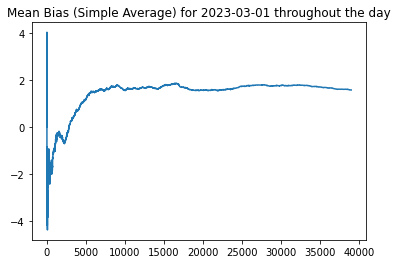

In [149]:
plt.plot(test_dataframe_small_bias_default.loc['2023-03-01'].values)
plt.title('Mean Bias (Simple Average) for 2023-03-01 throughout the day')

Other Methods of Calculating Bias:

In [150]:
%time test_dataframe_small_bias_reciprocal = test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='reciprocal'))

CPU times: user 15.3 s, sys: 3.6 ms, total: 15.3 s
Wall time: 15.3 s


Text(0.5, 1.0, 'Mean Bias (Reciprocal Weighted) for 2023-03-01 throughout the day')

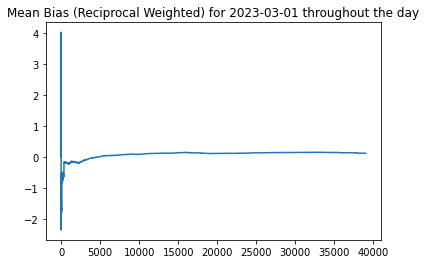

In [151]:
plt.plot(test_dataframe_small_bias_reciprocal.loc['2023-03-01'].values)
plt.title('Mean Bias (Reciprocal Weighted) for 2023-03-01 throughout the day')

In [152]:
%time test_dataframe_small_bias_log = test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log'))

CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 10s


Text(0.5, 1.0, 'Mean Bias (Log Weighted) for 2023-03-01 throughout the day')

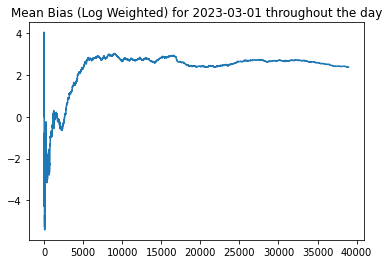

In [153]:
plt.plot(test_dataframe_small_bias_log.loc['2023-03-01'].values)
plt.title('Mean Bias (Log Weighted) for 2023-03-01 throughout the day')

In [154]:
%time test_dataframe_small_bias_log_reciprocal = test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log_reciprocal'))

CPU times: user 1min 15s, sys: 1.55 ms, total: 1min 15s
Wall time: 1min 15s


Text(0.5, 1.0, 'Mean Bias (Log_Reciprocal Weighted) for 2023-03-01 throughout the day')

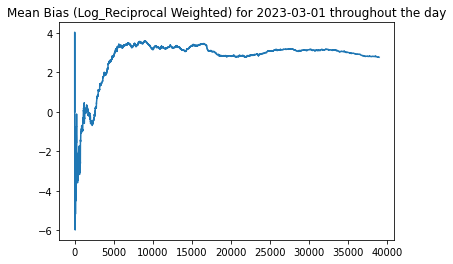

In [155]:
plt.plot(test_dataframe_small_bias_log_reciprocal.loc['2023-03-01'].values)
plt.title('Mean Bias (Log_Reciprocal Weighted) for 2023-03-01 throughout the day')

In [121]:
%time test_dataframe_small_bias_masked = test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large'))

CPU times: user 23 s, sys: 15.8 ms, total: 23.1 s
Wall time: 23.1 s


Text(0.5, 1.0, 'Mean Bias (Simple Average Masked) for 2023-03-01 throughout the day')

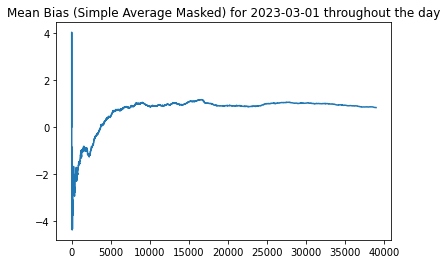

In [122]:
plt.plot(test_dataframe_small_bias_masked.loc['2023-03-01'].values)
plt.title('Mean Bias (Simple Average Masked) for 2023-03-01 throughout the day')

Calculating on the entire test dataframe

In [85]:
%time test_dataframe_bias_default = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))

CPU times: user 1min 6s, sys: 21.9 ms, total: 1min 6s
Wall time: 1min 6s


In [10]:
%time test_dataframe_bias_reciprocal = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='reciprocal'))
%time test_dataframe_bias_log = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log'))
%time test_dataframe_bias_logreciprocal = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log_reciprocal'))

CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 14s
CPU times: user 5min 15s, sys: 0 ns, total: 5min 15s
Wall time: 5min 15s
CPU times: user 5min 19s, sys: 0 ns, total: 5min 19s
Wall time: 5min 20s


In [14]:
summarize_col(train_dataframe_rmval.error, 'TRAIN SET BIAS')
summarize_col(val_dataframe.error, 'VALIDATION SET BIAS')
summarize_col(test_dataframe.error, 'TEST SET BIAS')

TRAIN SET BIAS      : -0.64, SD: 13.58, Max: 288.48, Min: -2788.66, 75%: 3.92, 25%: -5.42
VALIDATION SET BIAS : -0.62, SD: 15.22, Max: 213.01, Min: -2788.65, 75%: 4.36, 25%: -5.91
TEST SET BIAS       : -1.58, SD: 15.05, Max: 253.27, Min: -1066.09, 75%: 4.34, 25%: -7.45


In [12]:
%time test_dataframe_bias_masked_10 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 10))
%time test_dataframe_bias_masked_15 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 15))
%time test_dataframe_bias_masked_30 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 30))
%time test_dataframe_bias_masked_50 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 50))
%time test_dataframe_bias_masked_100 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 100))
%time test_dataframe_bias_masked_200 = test_dataframe.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 200))

CPU times: user 2min 9s, sys: 0 ns, total: 2min 9s
Wall time: 2min 10s
CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 55s
CPU times: user 1min 43s, sys: 0 ns, total: 1min 43s
Wall time: 1min 43s
CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 1min 38s
CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
Wall time: 1min 36s
CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


Checking model performance after debiasing using the different debiasing procedures:

It would appear that estimating the rolling weighted average bias is most effective when we disregard errors that are larger than 30bps - this is not a random number either, it is roughly 2 standard deviations from the mean error. This 15bps SD holds for out of sample observations, so both the validation and the test set. It is worth noting that there is a very small difference beyond the 2SD cutoff, so masking values that are 50, 100, 200bps or larger is mostly the same. 

Next we try to visualize and understand improvements to the model along different dimensions: 
1. We look at MAE by day to see if model performance degrades over time - in practice this means that the underlying distribution of the data is shifting and therefore the model's bias is getting larger and larger. The output from the analyze_debiasing() function does this: we see that MAE for the original predictions does indeed increase over time, but we also see that the debiasing helps more and more over time as the debiased MAE becomes better and better as time passes. 
2. We look at MAE throughout the day, and generally the improvement to MAE stabilizes once there are sufficient trades to estimate the intra-day bias. We look at the first 500 trades for reference, and sometimes the original prediction's MAE is better, but it loses that lead over time 
3. We look at win rates on trades throughout the day (a win is when prediction X is closer in absolute terms to the truth than prediction Y). Similar to MAE, the debiased predictions have a higher win rate 

In [16]:
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_reciprocal.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_log.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_logreciprocal.values)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.114, Corrected MAE: 9.056
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -1.417, Corrected MAE: 9.281
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.761, Corrected MAE: 9.163
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 1.081, Corrected MAE: 9.252


In [17]:
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_10.fillna(0).values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_15.fillna(0).values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_30.fillna(0).values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_50.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_100.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_masked_200.values)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.825, Corrected MAE: 9.129
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.469, Corrected MAE: 9.077
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.007, Corrected MAE: 9.047
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.097, Corrected MAE: 9.050
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.087, Corrected MAE: 9.055
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.094, Corrected MAE: 9.055


Closer Visualization of Debiased Results

In [26]:
summary_mask_30 = analyze_debiasing_MAE(test_dataframe, test_dataframe_bias_masked_30.values)
summary_mask_30

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-03-01,8.613,8.492,-0.121
2023-03-02,8.355,8.213,-0.142
2023-03-03,8.474,8.365,-0.109
2023-03-06,8.653,8.539,-0.114
2023-03-07,8.577,8.571,-0.006
2023-03-08,8.473,8.467,-0.005
2023-03-09,8.487,8.448,-0.039
2023-03-10,9.106,9.016,-0.090
2023-03-13,9.367,9.315,-0.052


In [27]:
summary_default = analyze_debiasing_MAE(test_dataframe, test_dataframe_bias_default.values)
summary_default 

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-03-01,8.613,8.487,-0.126
2023-03-02,8.355,8.209,-0.146
2023-03-03,8.474,8.366,-0.109
2023-03-06,8.653,8.542,-0.112
2023-03-07,8.577,8.576,-0.001
2023-03-08,8.473,8.487,0.014
2023-03-09,8.487,8.524,0.037
2023-03-10,9.106,9.040,-0.066
2023-03-13,9.367,9.307,-0.060


OVERALL ORIGINAL MAE: 8.61, OVERALL DEBIASED MAE: 8.49


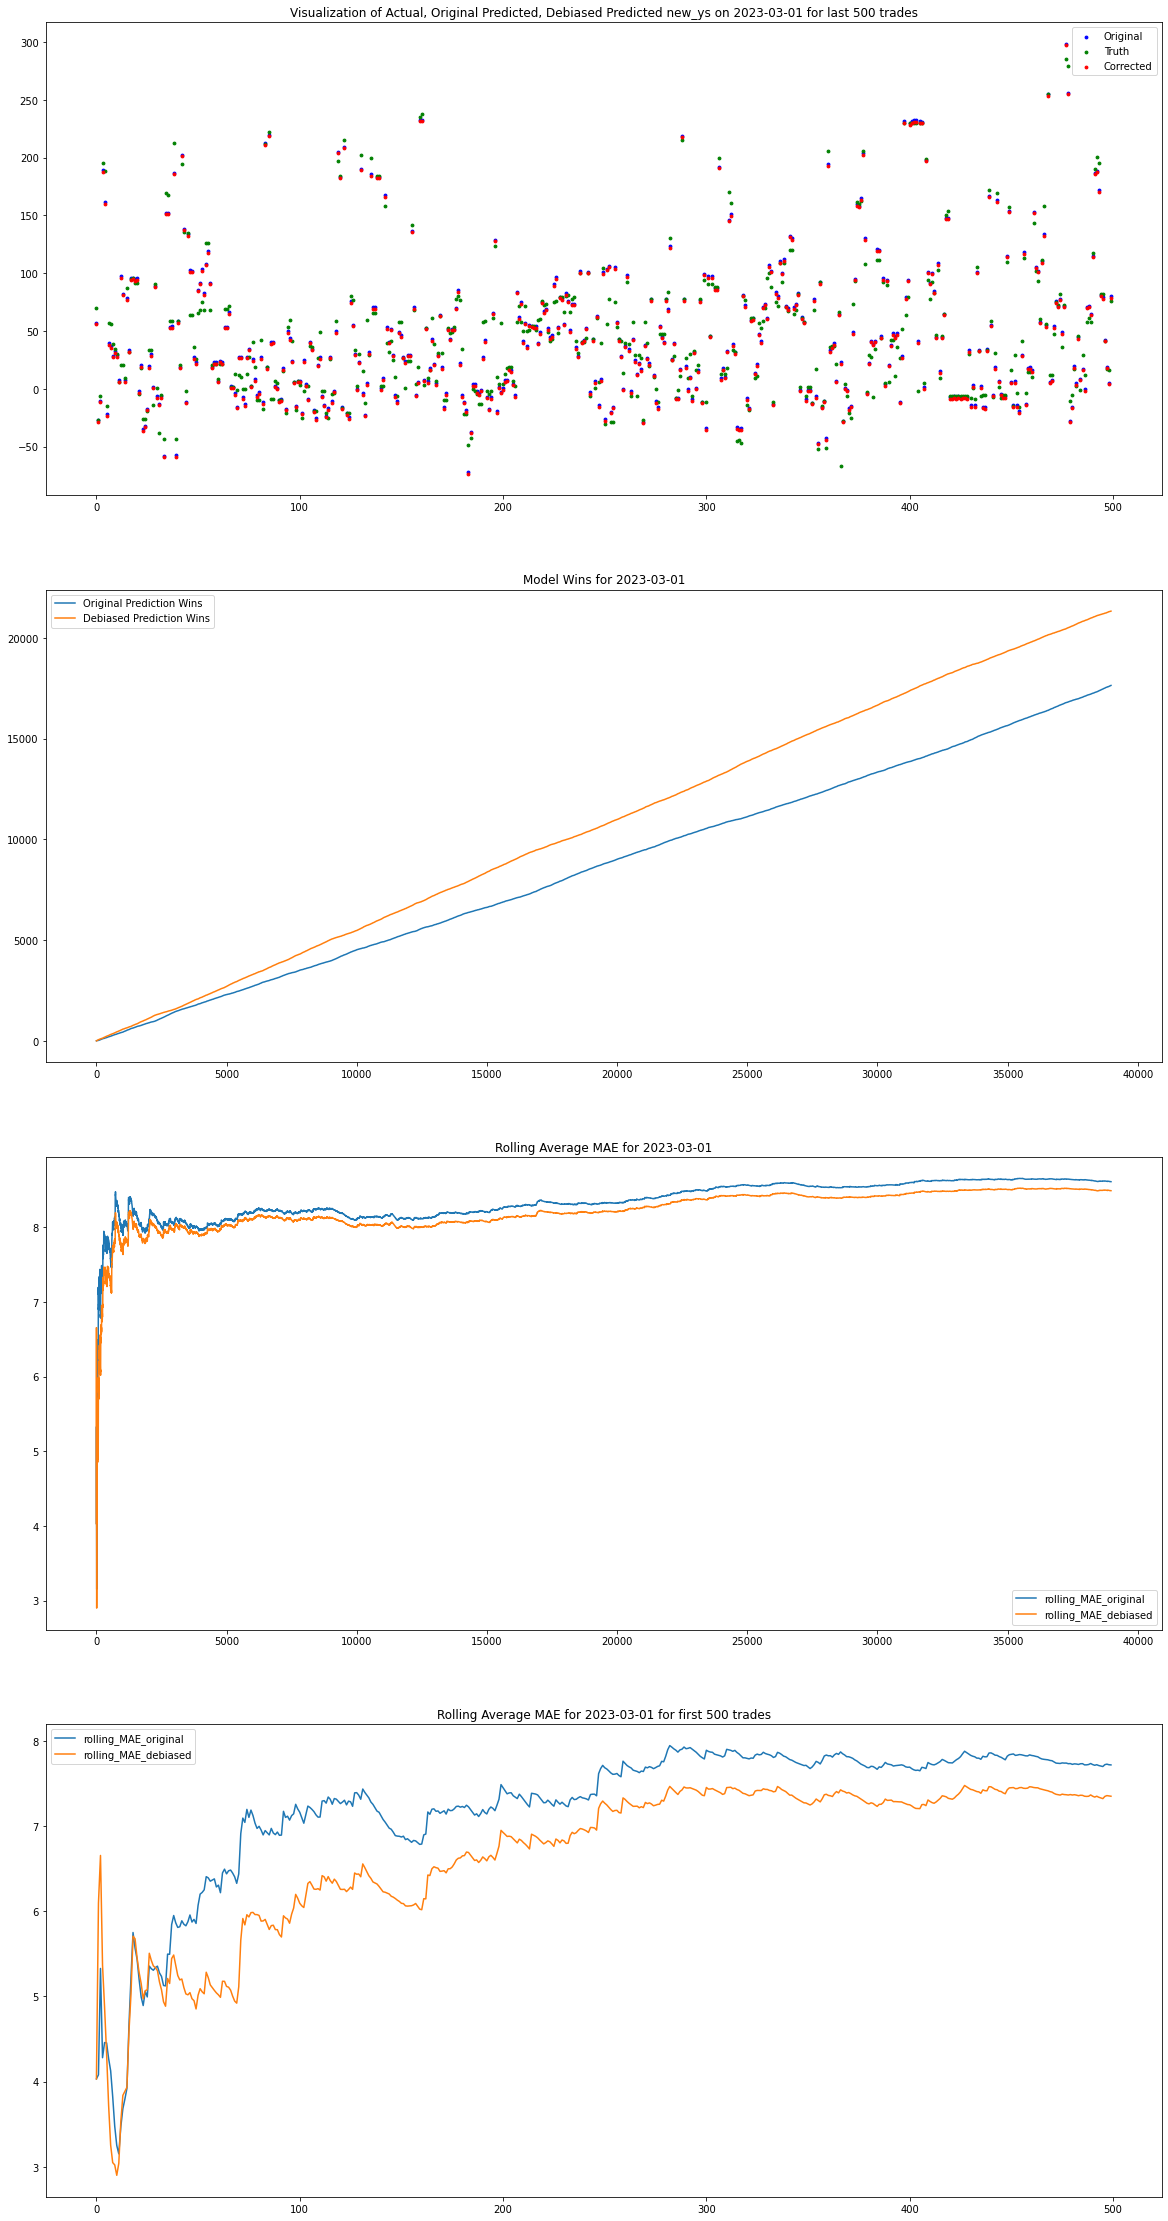

In [170]:
_ = analyze_debiasing_day('2023-03-01', test_dataframe, test_dataframe_bias_masked_30.values, first_N_trades=500, last_N_trades=500)

OVERALL ORIGINAL MAE: 8.61, OVERALL DEBIASED MAE: 8.49


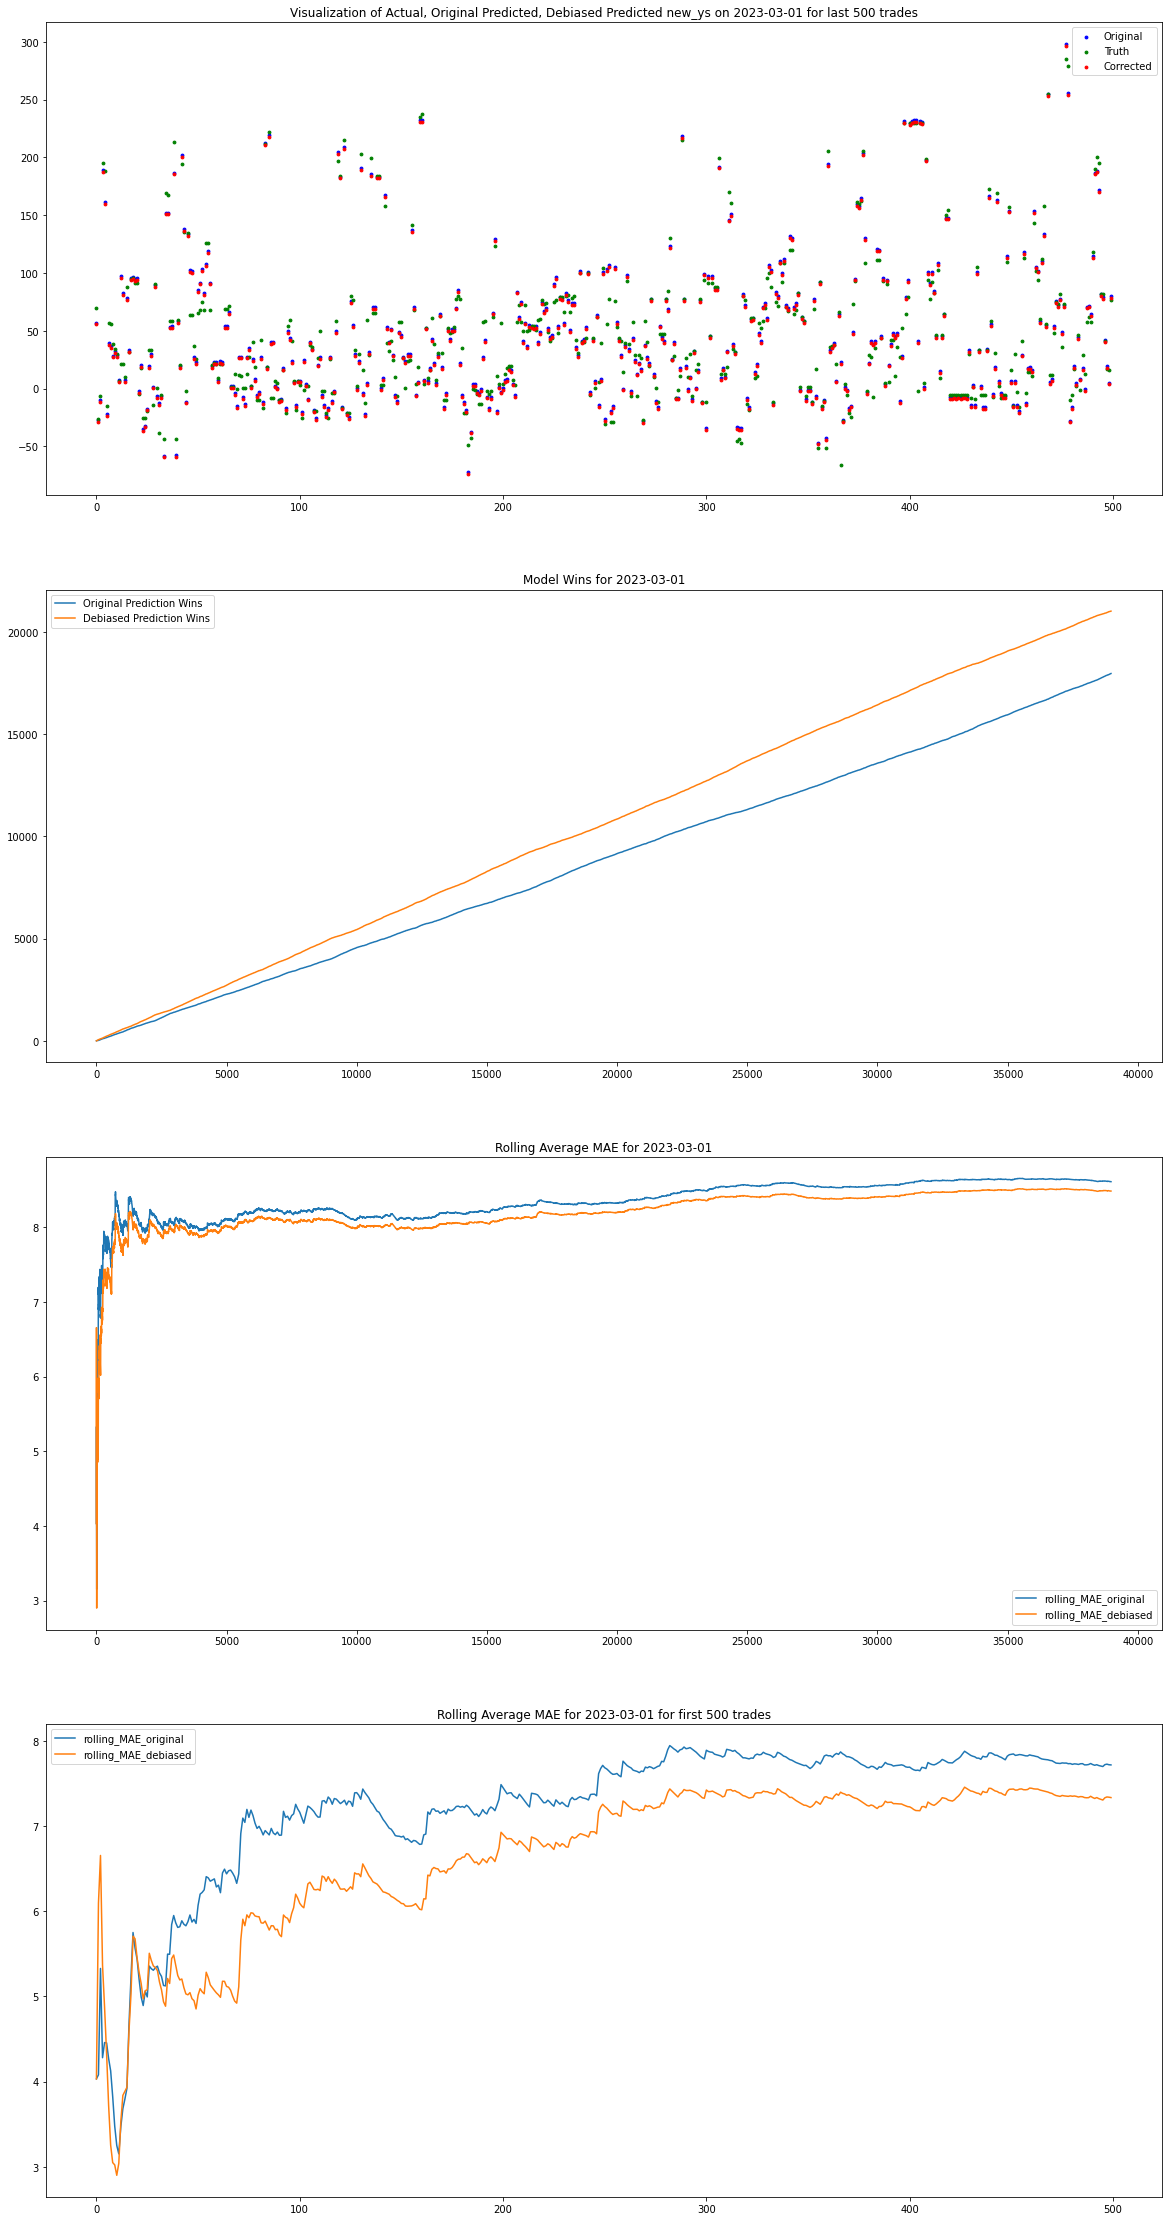

In [115]:
summary = analyze_debiasing_day('2023-03-01', test_dataframe, test_dataframe_bias_default.values, first_N_trades=500, last_N_trades=500)

## Groupby: Trade Date and Maturity

In [70]:
%%time

duration1 = [1, 2, 5, 10, 15, 30, 50]
duration2 = [1, 5, 10, 15, 30, 50]
duration3 = [1, 10, 20, 30, 50]
duration4 = [1, 15, 50]

train_dataframe_rmval['duration_bucket1'] = pd.cut(train_dataframe_rmval['calc_duration'], bins=duration1)
val_dataframe['duration_bucket1'] = pd.cut(val_dataframe['calc_duration'], bins=duration1)
test_dataframe['duration_bucket1'] = pd.cut(test_dataframe['calc_duration'], bins=duration1)

train_dataframe_rmval['duration_bucket2'] = pd.cut(train_dataframe_rmval['calc_duration'], bins=duration2)
val_dataframe['duration_bucket2'] = pd.cut(val_dataframe['calc_duration'], bins=duration2)
test_dataframe['duration_bucket2'] = pd.cut(test_dataframe['calc_duration'], bins=duration2)

train_dataframe_rmval['duration_bucket3'] = pd.cut(train_dataframe_rmval['calc_duration'], bins=duration3)
val_dataframe['duration_bucket3'] = pd.cut(val_dataframe['calc_duration'], bins=duration3)
test_dataframe['duration_bucket3'] = pd.cut(test_dataframe['calc_duration'], bins=duration3)

train_dataframe_rmval['duration_bucket4'] = pd.cut(train_dataframe_rmval['calc_duration'], bins=duration4)
val_dataframe['duration_bucket4'] = pd.cut(val_dataframe['calc_duration'], bins=duration4)
test_dataframe['duration_bucket4'] = pd.cut(test_dataframe['calc_duration'], bins=duration4)

CPU times: user 305 ms, sys: 8 µs, total: 305 ms
Wall time: 308 ms


In [50]:
%time test_dataframe_bias_date_duration_default  = test_dataframe.groupby(['trade_date','duration_bucket'])['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_bias_date_duration1_default  = test_dataframe.groupby(['trade_date','duration_bucket1'])['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_bias_date_duration2_default  = test_dataframe.groupby(['trade_date','duration_bucket2'])['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_bias_date_duration3_default  = test_dataframe.groupby(['trade_date','duration_bucket3'])['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_bias_date_duration4_default  = test_dataframe.groupby(['trade_date','duration_bucket4'])['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))

CPU times: user 49.6 s, sys: 11.4 ms, total: 49.6 s
Wall time: 49.7 s
CPU times: user 53.1 s, sys: 3.65 ms, total: 53.1 s
Wall time: 53.1 s
CPU times: user 54.6 s, sys: 6.92 ms, total: 54.6 s
Wall time: 54.6 s


In [72]:
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_date_duration_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_date_duration1_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_date_duration2_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_date_duration3_default.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_date_duration4_default.values)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.114, Corrected MAE: 9.056
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.129, Corrected MAE: 9.250
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.132, Corrected MAE: 9.197
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.106, Corrected MAE: 9.108
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.110, Corrected MAE: 9.076
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.110, Corrected MAE: 9.064


OVERALL ORIGINAL MAE: 8.61, OVERALL DEBIASED MAE: 8.52


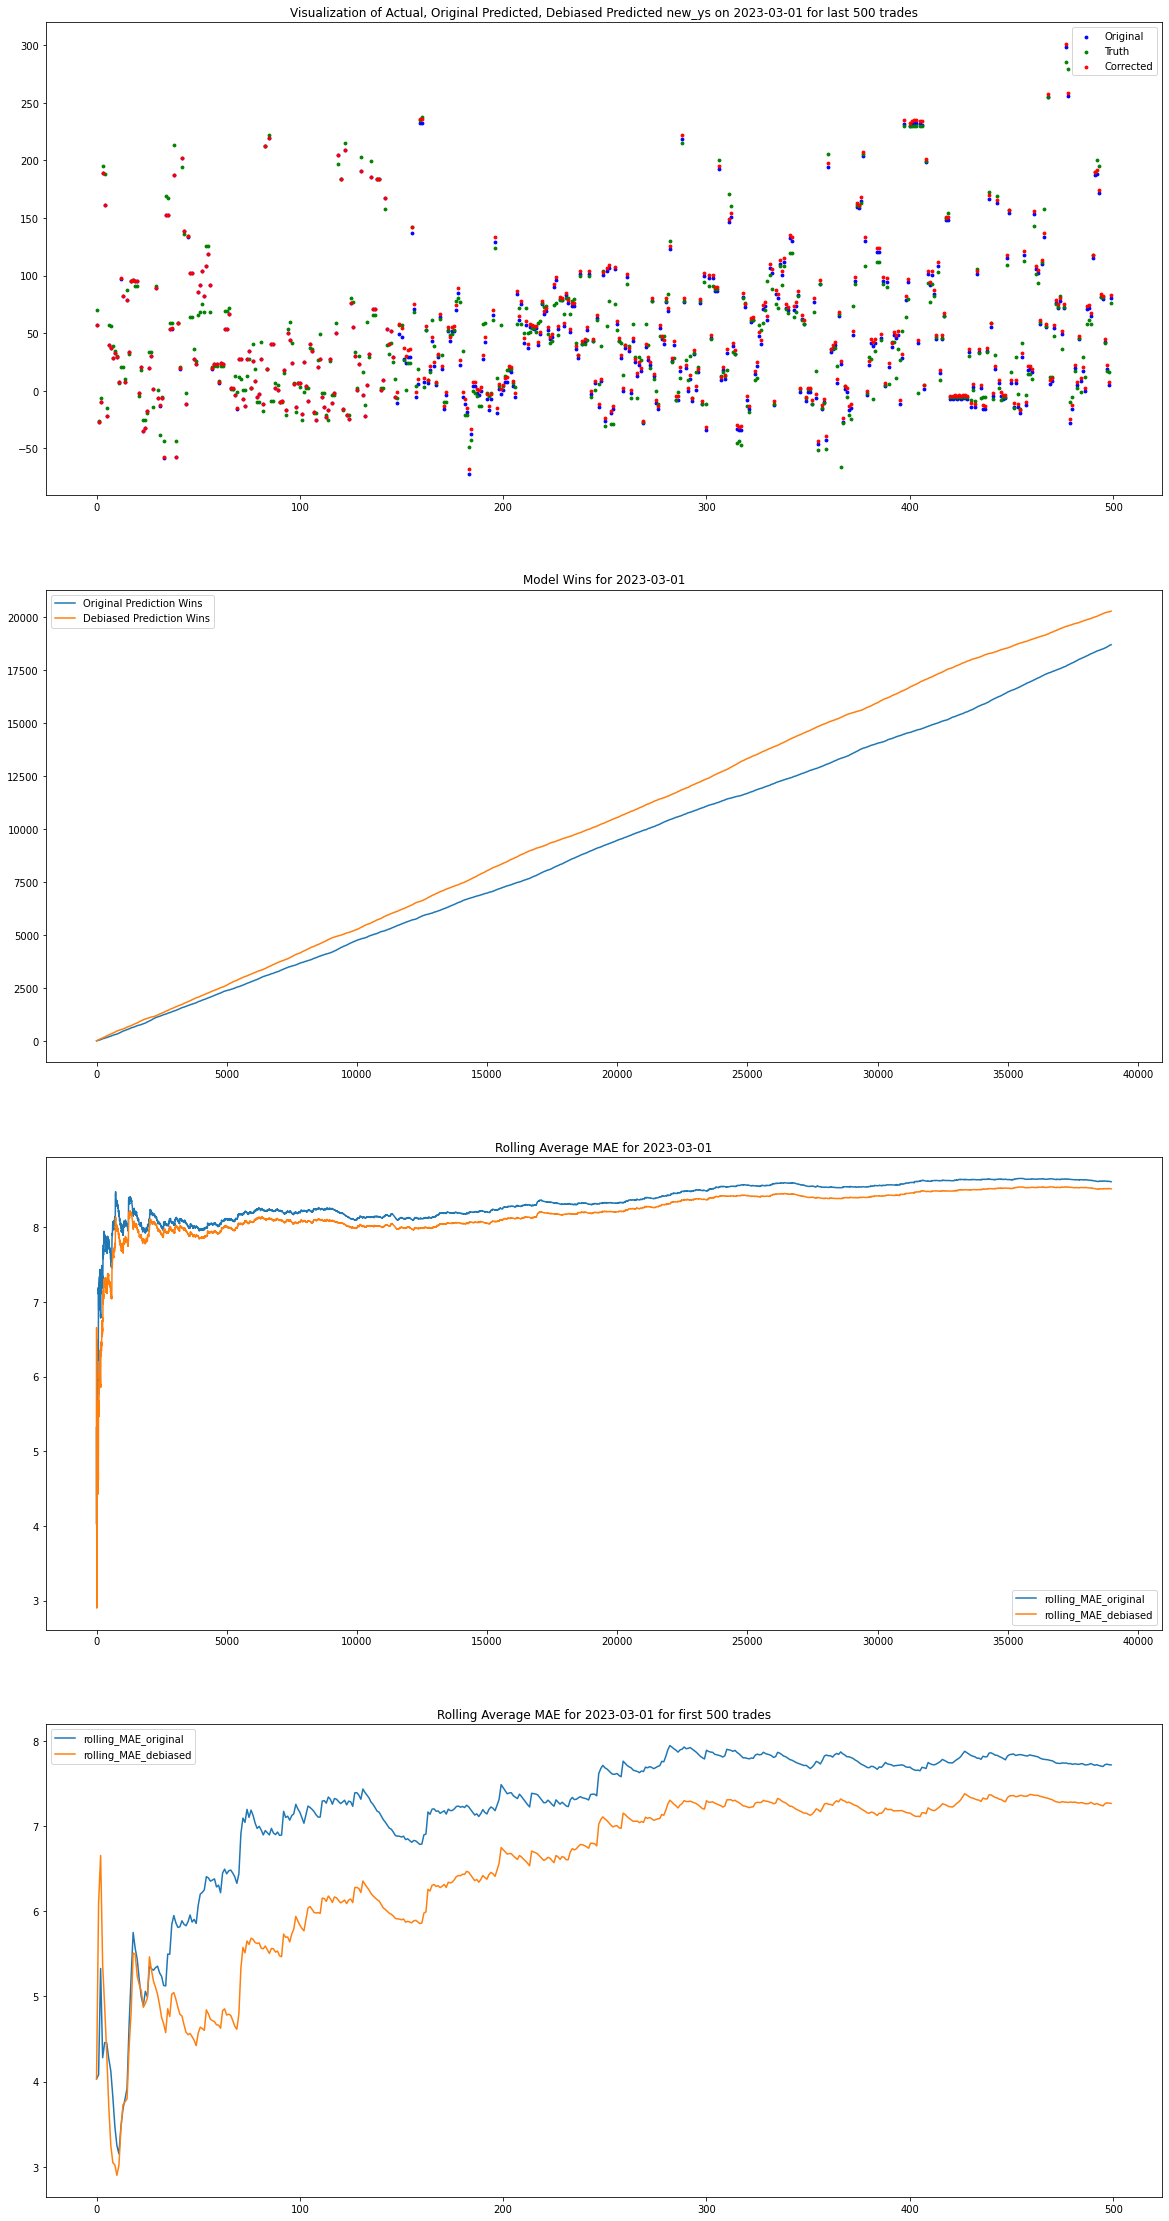

In [69]:
summary = analyze_debiasing_day('2023-03-01', test_dataframe, test_dataframe_bias_date_duration3_default.values, first_N_trades=500, last_N_trades=500)

In [96]:
def compare_bias_results(df, bias1: dict, bias2: dict): 
    
    bias1_name = list(bias1.keys())[0]
    bias2_name = list(bias2.keys())[0]
    bias1 = bias1[bias1_name]
    bias2 = bias2[bias2_name]
    
    summary1 = analyze_debiasing_MAE(df, bias1.values)
    summary2 = analyze_debiasing_MAE(df, bias2.values)

    comparison = summary1[['Original MAE','Corrected MAE']].join(summary2[['Corrected MAE']], lsuffix=f'_{bias1_name}', rsuffix=f'_{bias2_name}')
    comparison['1>2'] = np.where(comparison[f'Corrected MAE_{bias1_name}'] > comparison[f'Corrected MAE_{bias2_name}'], 1, 0)
    
    return comparison

In [101]:
compare_bias_results(test_dataframe, {'date':test_dataframe_bias_default}, {'date_duration2':test_dataframe_bias_date_duration2_default})

,Original MAE,Corrected MAE_date,Corrected MAE_date_duration2,1>2
trade_date,,,,
2023-03-01,8.613,8.487,8.517,0
2023-03-02,8.355,8.209,8.238,0
2023-03-03,8.474,8.366,8.383,0
2023-03-06,8.653,8.542,8.555,0
2023-03-07,8.577,8.576,8.587,0
2023-03-08,8.473,8.487,8.523,0
2023-03-09,8.487,8.524,8.555,0
2023-03-10,9.106,9.040,9.049,0
2023-03-13,9.367,9.307,9.408,0


In [97]:
compare_bias_results(test_dataframe, {'date':test_dataframe_bias_default}, {'date_duration3':test_dataframe_bias_date_duration3_default})

,Original MAE,Corrected MAE_date,Corrected MAE_date_duration3,1>2
trade_date,,,,
2023-03-01,8.613,8.487,8.516,0
2023-03-02,8.355,8.209,8.228,0
2023-03-03,8.474,8.366,8.366,0
2023-03-06,8.653,8.542,8.546,0
2023-03-07,8.577,8.576,8.580,0
2023-03-08,8.473,8.487,8.504,0
2023-03-09,8.487,8.524,8.530,0
2023-03-10,9.106,9.040,9.022,1
2023-03-13,9.367,9.307,9.379,0


## Weighting by other Variables:

### Finding the most efficient implementation 

Using pandas groupby() followed by expanding() is troublesome. The implementation below tries to use this with .apply() to map a function to each of the grouped and rolled dataframes within the ExpandingGroupBy object, but the function has trouble taking in a function that performs calculations multiple columns (in this case here 'error' and 'quantity'). The initial workaround was to retrieve the weight column ('quantity') using dataframe indexing. 

loc works in O(n) time for unsorted and non-unique indices but supposedly in O(log n) time for unique and sorted indices. iloc works in O(n) time and converting the pandas column to a dictionary then retrieving from the dictionary also takes O(n) time. In the end, iloc seems to work faster than loc, not sure why. In general, all 3 take around 20 mins for the entire test dataframe of 700k rows.

But it turns out that the most primitive implementation is the best. We convert the ExpandingGroupBy object to a list then iterate across each sub-dataframe and calculate the weighted average for each of those dfs

In [239]:
def expanding_weighted_average_extended(data, data_dict, method = 'default', upper_mask = 0, lower_mask = 0):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    errors = data.iloc[:-1]
    if len(errors) == 0: return 0 

    indices = errors.index.tolist()
    errors = errors.to_numpy()
    
    #dictionary implementation is slightly faster than dataframe.loc 
    #a general note: df.iloc always has complexity O(n) while df.loc has complexity O(logn) if we have a unique and sorted index 
    #dict.get() is constant time but since we are calling it n times, the overall data retrieval still has complexity O(n) 
    weights = np.array([data_dict.get(idx) for idx in indices])

    if upper_mask:
        weights = np.where(weights > upper_mask, 0, weights)
    if lower_mask: 
        weights = np.where(weights < lower_mask, 0, weights)
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

Run 2000 lookups of size N = 20000, which is about the average if we have 40-50k trades a day

In [226]:
indices = [np.random.choice(range(len(test_dataframe)), 20000, replace=False) for n in range(2000)]

In [227]:
%%time
for index in indices:
    _ = test_dataframe.loc[index, "quantity"];

CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.12 s


In [228]:
%%time
col_idx = test_dataframe.columns.get_loc("quantity")
for index in indices:
    _ = test_dataframe.iloc[index, col_idx];

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


In [229]:
%%time
data_col = test_dataframe['quantity']
for index in indices:
    _ = data_col.loc[index].values


CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


In [230]:
%%time
data_col = test_dataframe['quantity']
for index in indices:
    _ = data_col.iloc[index].values

CPU times: user 788 ms, sys: 0 ns, total: 788 ms
Wall time: 787 ms


In [231]:
%%time
data_col_dict = test_dataframe['quantity'].to_dict()
for index in indices:
    np.array([data_col_dict.get(x) for x in index]);

CPU times: user 31.7 s, sys: 15.9 ms, total: 31.7 s
Wall time: 31.7 s


In [237]:
def expanding_weighted_average_extendedloc(data, weighting_col, method = 'default', upper_mask = 0, lower_mask = 0):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    errors = data.iloc[:-1]
    if len(errors) == 0: return 0 

    indices = errors.index.tolist()
    errors = errors.to_numpy()
    weights = weighting_col.loc[indices]

    if upper_mask:
        weights = np.where(weights > upper_mask, 0, weights)
    if lower_mask: 
        weights = np.where(weights < lower_mask, 0, weights)
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

In [234]:
def expanding_weighted_average_extended_iloc(data, weighting_col, method = 'default', upper_mask = 0, lower_mask = 0):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    errors = data.iloc[:-1]
    if len(errors) == 0: return 0 

    indices = errors.index.tolist()
    errors = errors.to_numpy()
    weights = weighting_col.iloc[indices]

    if upper_mask:
        weights = np.where(weights > upper_mask, 0, weights)
    if lower_mask: 
        weights = np.where(weights < lower_mask, 0, weights)
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

In [236]:
%%time

weighting_col = test_dataframe_small['quantity']
test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_extended_iloc(x, weighting_col, method='default'))

CPU times: user 4min 44s, sys: 18.5 ms, total: 4min 44s
Wall time: 4min 44s


trade_date        
2023-03-01  0         0.000
            1         4.032
            2         0.580
            3        -1.919
            4        -1.739
                      ...  
2023-03-06  141681    1.442
            141682    1.442
            141683    1.442
            141684    1.442
            141685    1.442
Name: error, Length: 141686, dtype: float64

In [241]:
%%time

weighting_col = test_dataframe_small['quantity']
test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_extendedloc(x, weighting_col, method='default'))

CPU times: user 6min 30s, sys: 82.6 ms, total: 6min 30s
Wall time: 6min 30s


trade_date        
2023-03-01  0         0.000
            1         4.032
            2         0.580
            3        -1.919
            4        -1.739
                      ...  
2023-03-06  141681    1.442
            141682    1.442
            141683    1.442
            141684    1.442
            141685    1.442
Name: error, Length: 141686, dtype: float64

In [240]:
%%time
data_dict = test_dataframe_small['quantity'].to_dict()
test_dataframe_small.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_extended(x, data_dict, method='default'))

CPU times: user 6min 2s, sys: 50.6 ms, total: 6min 2s
Wall time: 6min 2s


trade_date        
2023-03-01  0         0.000
            1         4.032
            2         0.580
            3        -1.919
            4        -1.739
                      ...  
2023-03-06  141681    1.442
            141682    1.442
            141683    1.442
            141684    1.442
            141685    1.442
Name: error, Length: 141686, dtype: float64

### Running on entire dataset

In [51]:
def expanding_weighted_average_extended_iloc(data, weighting_col, method = 'default', upper_mask = 0, lower_mask = 0):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    errors = data.iloc[:-1]
    if len(errors) == 0: return 0 

    indices = errors.index.tolist()
    errors = errors.to_numpy()
    weights = weighting_col.iloc[indices]

    if upper_mask:
        weights = np.where(weights > upper_mask, 0, weights)
    if lower_mask: 
        weights = np.where(weights < lower_mask, 0, weights)
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

def apply_expanding_weighted_average_extended(df, weighting_col_name, method, groupby_cols, upper_mask = 0, lower_mask = 0):

    weighting_col = df[weighting_col_name]
    return df.groupby(groupby_cols)['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_extended_iloc(x, weighting_col, method=method, upper_mask = upper_mask, lower_mask = lower_mask))


def expanding_weighted_average_test(data, weighting_col, error_col = 'error'):
    #convert to numpy and mask the most recent value, which is the current trade
    #to be closer to production, the level of masking probably has to be more 
    data = data.iloc[:-1]
    if len(data) == 0: return 0 

    errors = data[error_col].to_numpy()
    weights = data[weighting_col].to_numpy()
        
    return np.sum(np.multiply(errors,weights))/np.sum(weights)

In [21]:
test_dataframe['quantity_raw'] = 10** test_dataframe['quantity']

In [18]:
%%time
group_expanding_dataframes = list(test_dataframe.groupby('trade_date')[['error','quantity']].expanding(min_periods=1, method='table'))
test_dataframe_bias_quantity_weighted_test = []
for sub_df in group_expanding_dataframes:
    test_dataframe_bias_quantity_weighted_test.append(expanding_weighted_average_test(sub_df, 'quantity'))

CPU times: user 2min 26s, sys: 0 ns, total: 2min 26s
Wall time: 2min 26s


In [22]:
%%time
group_expanding_dataframes = list(test_dataframe.groupby('trade_date')[['error','quantity_raw']].expanding(min_periods=1, method='table'))
test_dataframe_bias_quantityraw_weighted_test = []
for sub_df in group_expanding_dataframes:
    test_dataframe_bias_quantityraw_weighted_test.append(expanding_weighted_average_test(sub_df, 'quantity_raw'))

CPU times: user 2min 18s, sys: 0 ns, total: 2min 18s
Wall time: 2min 18s


In [25]:
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_default.values)
# debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_quantityraw_weighted.values)
# debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_quantity_weighted.values)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_quantity_weighted_test)
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_quantityraw_weighted_test)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.113, Corrected MAE: 9.056
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.091, Corrected MAE: 9.054
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.423, Corrected MAE: 9.127


In [80]:
test_dataframe['debiased_prediction'] = test_dataframe['prediction'] -  test_dataframe_bias_default.values

<AxesSubplot:xlabel='prediction', ylabel='debiased_prediction'>

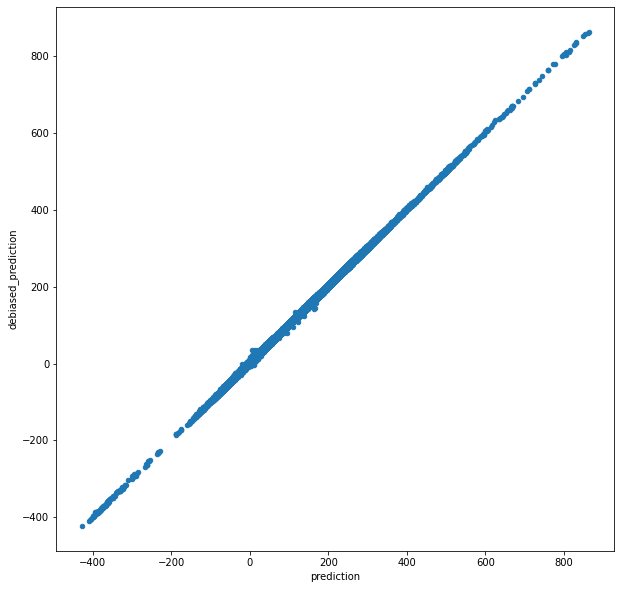

In [92]:
test_dataframe.plot('prediction', 'debiased_prediction', kind='scatter', figsize=(10, 10))

<AxesSubplot:xlabel='new_ys', ylabel='prediction'>

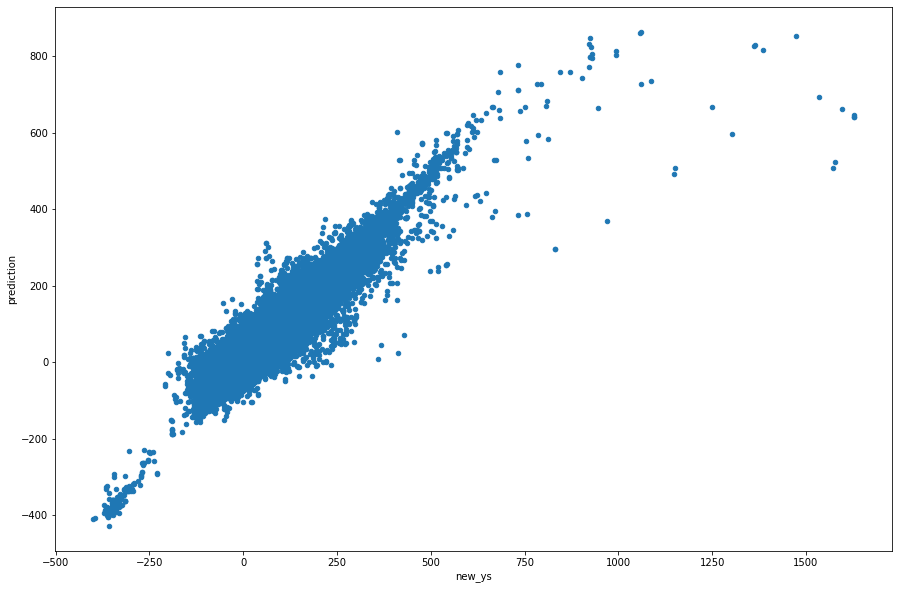

In [95]:
test_dataframe.plot('new_ys', 'prediction', kind='scatter', figsize=(15, 10))

<AxesSubplot:xlabel='new_ys', ylabel='debiased_prediction'>

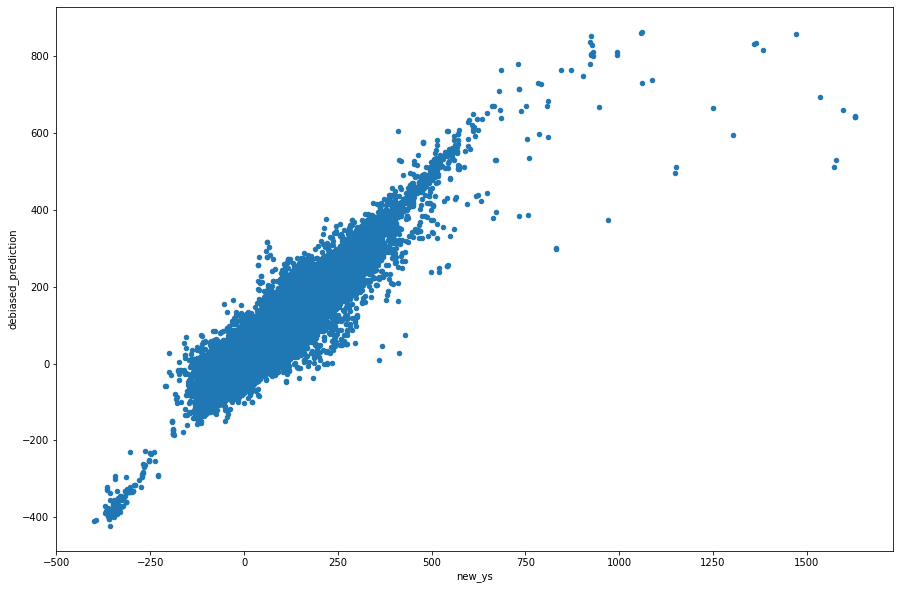

In [96]:
test_dataframe.plot('new_ys', 'debiased_prediction', kind='scatter', figsize=(15, 10))

## Testing Debiasing on Other Models


We also test different window sizes rather than using pd.expanding(), which takes all preceding trades rather than the last X preceding trades.

**The high level findings are as follows:** <br>
**LightGBM:** MAE improves by ~0.45bps <br>
**new_ys_realtime:** similar to new_ys, MAE improves by around ~0.28<br>
**Different window sizes**: a sufficiently large window size does not cost us on MAE. In fact, there is a marginal but likely noisy improvement of almost 0.01. But this is negligible. At the very least, this presents fewer computations and hence, faster processing times.<br>

### Testing LGBM

In [6]:
for col in CATEGORICAL_FEATURES + BINARY:
    train_dataframe_rmval[col] = train_dataframe_rmval[col].astype('category')
    test_dataframe[col] = test_dataframe[col].astype('category')

In [17]:
%%time

TARGET = 'new_ys'
ensemble_size = 5
LGBM_predictors = set(PREDICTORS) - {'trade_history', 'target_attention_features', 'yield_spread'} 
model_baseline = traintest(LGBM_predictors, train_dataframe_rmval, test_dataframe, TARGET, n = ensemble_size)

Training 5 modelswith 30 columns on 1204369 examples starting 2023-01-01
Evaluating new_ys predictions on 708432 examples starting 2023-03-01

new_ys n = 708432  bias = -1.11  MAE=12.42 +/- 15.60 (0.02)	 median  8.31
CPU times: user 6min 4s, sys: 1.03 s, total: 6min 5s
Wall time: 6min 6s


In [20]:
lgbm_predictions = model_baseline.predict(test_dataframe[LGBM_predictors])
test_dataframe['lgbm_prediction'] = lgbm_predictions
test_dataframe['lgbm_error'] = test_dataframe['lgbm_prediction'] - test_dataframe['new_ys']

In [53]:
%time test_dataframe_bias_date_default_LGBM  = test_dataframe.groupby(['trade_date'])['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_bias_reciprocal_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='reciprocal'))
%time test_dataframe_bias_log_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log'))
%time test_dataframe_bias_logreciprocal_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log_reciprocal'))
%time test_dataframe_bias_masked_10_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 10))
%time test_dataframe_bias_masked_15_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 15))
%time test_dataframe_bias_masked_30_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 30))
%time test_dataframe_bias_masked_50_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 50))
%time test_dataframe_bias_masked_100_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 100))
%time test_dataframe_bias_masked_200_LGBM = test_dataframe.groupby('trade_date')['lgbm_error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 200))

CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s
CPU times: user 5min 17s, sys: 0 ns, total: 5min 17s
Wall time: 5min 17s
CPU times: user 5min 18s, sys: 11.4 ms, total: 5min 18s
Wall time: 5min 18s
CPU times: user 2min 20s, sys: 2.29 ms, total: 2min 20s
Wall time: 2min 20s
CPU times: user 2min 5s, sys: 11.7 ms, total: 2min 5s
Wall time: 2min 5s
CPU times: user 1min 46s, sys: 20.5 ms, total: 1min 46s
Wall time: 1min 46s
CPU times: user 1min 40s, sys: 21.3 ms, total: 1min 40s
Wall time: 1min 41s
CPU times: user 1min 34s, sys: 25.5 ms, total: 1min 34s
Wall time: 1min 34s
CPU times: user 1min 39s, sys: 9.68 ms, total: 1min 39s
Wall time: 1min 39s


In [52]:
%%time
group_expanding_dataframes = list(test_dataframe.groupby('trade_date')[['lgbm_error','quantity']].expanding(min_periods=1, method='table'))
test_dataframe_bias_quantity_weighted_LGBM = []
for sub_df in group_expanding_dataframes:
    test_dataframe_bias_quantity_weighted_LGBM.append(expanding_weighted_average_test(sub_df, 'quantity', error_col = 'lgbm_error'))

CPU times: user 2min 25s, sys: 8.63 ms, total: 2min 25s
Wall time: 2min 25s


In [57]:
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_date_default_LGBM.values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_reciprocal_LGBM.values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_log_LGBM.values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_logreciprocal_LGBM.values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_10_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_15_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_30_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_50_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_100_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_masked_200_LGBM.fillna(0).values)
debias_series(test_dataframe['lgbm_prediction'], test_dataframe.new_ys, test_dataframe_bias_quantity_weighted_LGBM)

Original bias: 1.108, Original MAE: 12.423, Corrected bias: 0.049, Corrected MAE: 11.975
Original bias: 1.108, Original MAE: 12.423, Corrected bias: 0.950, Corrected MAE: 12.337
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.047, Corrected MAE: 12.120
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.109, Corrected MAE: 12.202
Original bias: 1.108, Original MAE: 12.423, Corrected bias: 0.556, Corrected MAE: 12.186
Original bias: 1.108, Original MAE: 12.423, Corrected bias: 0.269, Corrected MAE: 12.071
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.026, Corrected MAE: 11.965
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.018, Corrected MAE: 11.959
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.010, Corrected MAE: 11.968
Original bias: 1.108, Original MAE: 12.423, Corrected bias: -0.009, Corrected MAE: 11.971
Original bias: 1.108, Original MAE: 12.423, Corrected bias: 0.091, Corrected MAE: 11.974


In [42]:
analyze_debiasing_MAE(test_dataframe, test_dataframe_bias_date_default_LGBM.values, prediction_col='lgbm_prediction')

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-03-01,11.816,11.601,-0.215
2023-03-02,11.488,11.515,0.027
2023-03-03,12.123,11.338,-0.784
2023-03-06,12.313,11.480,-0.834
2023-03-07,12.160,11.488,-0.672
2023-03-08,12.039,11.306,-0.733
2023-03-09,11.533,11.054,-0.479
2023-03-10,13.322,11.150,-2.172
2023-03-13,14.332,12.037,-2.294


OVERALL ORIGINAL MAE: 11.82, OVERALL DEBIASED MAE: 11.60


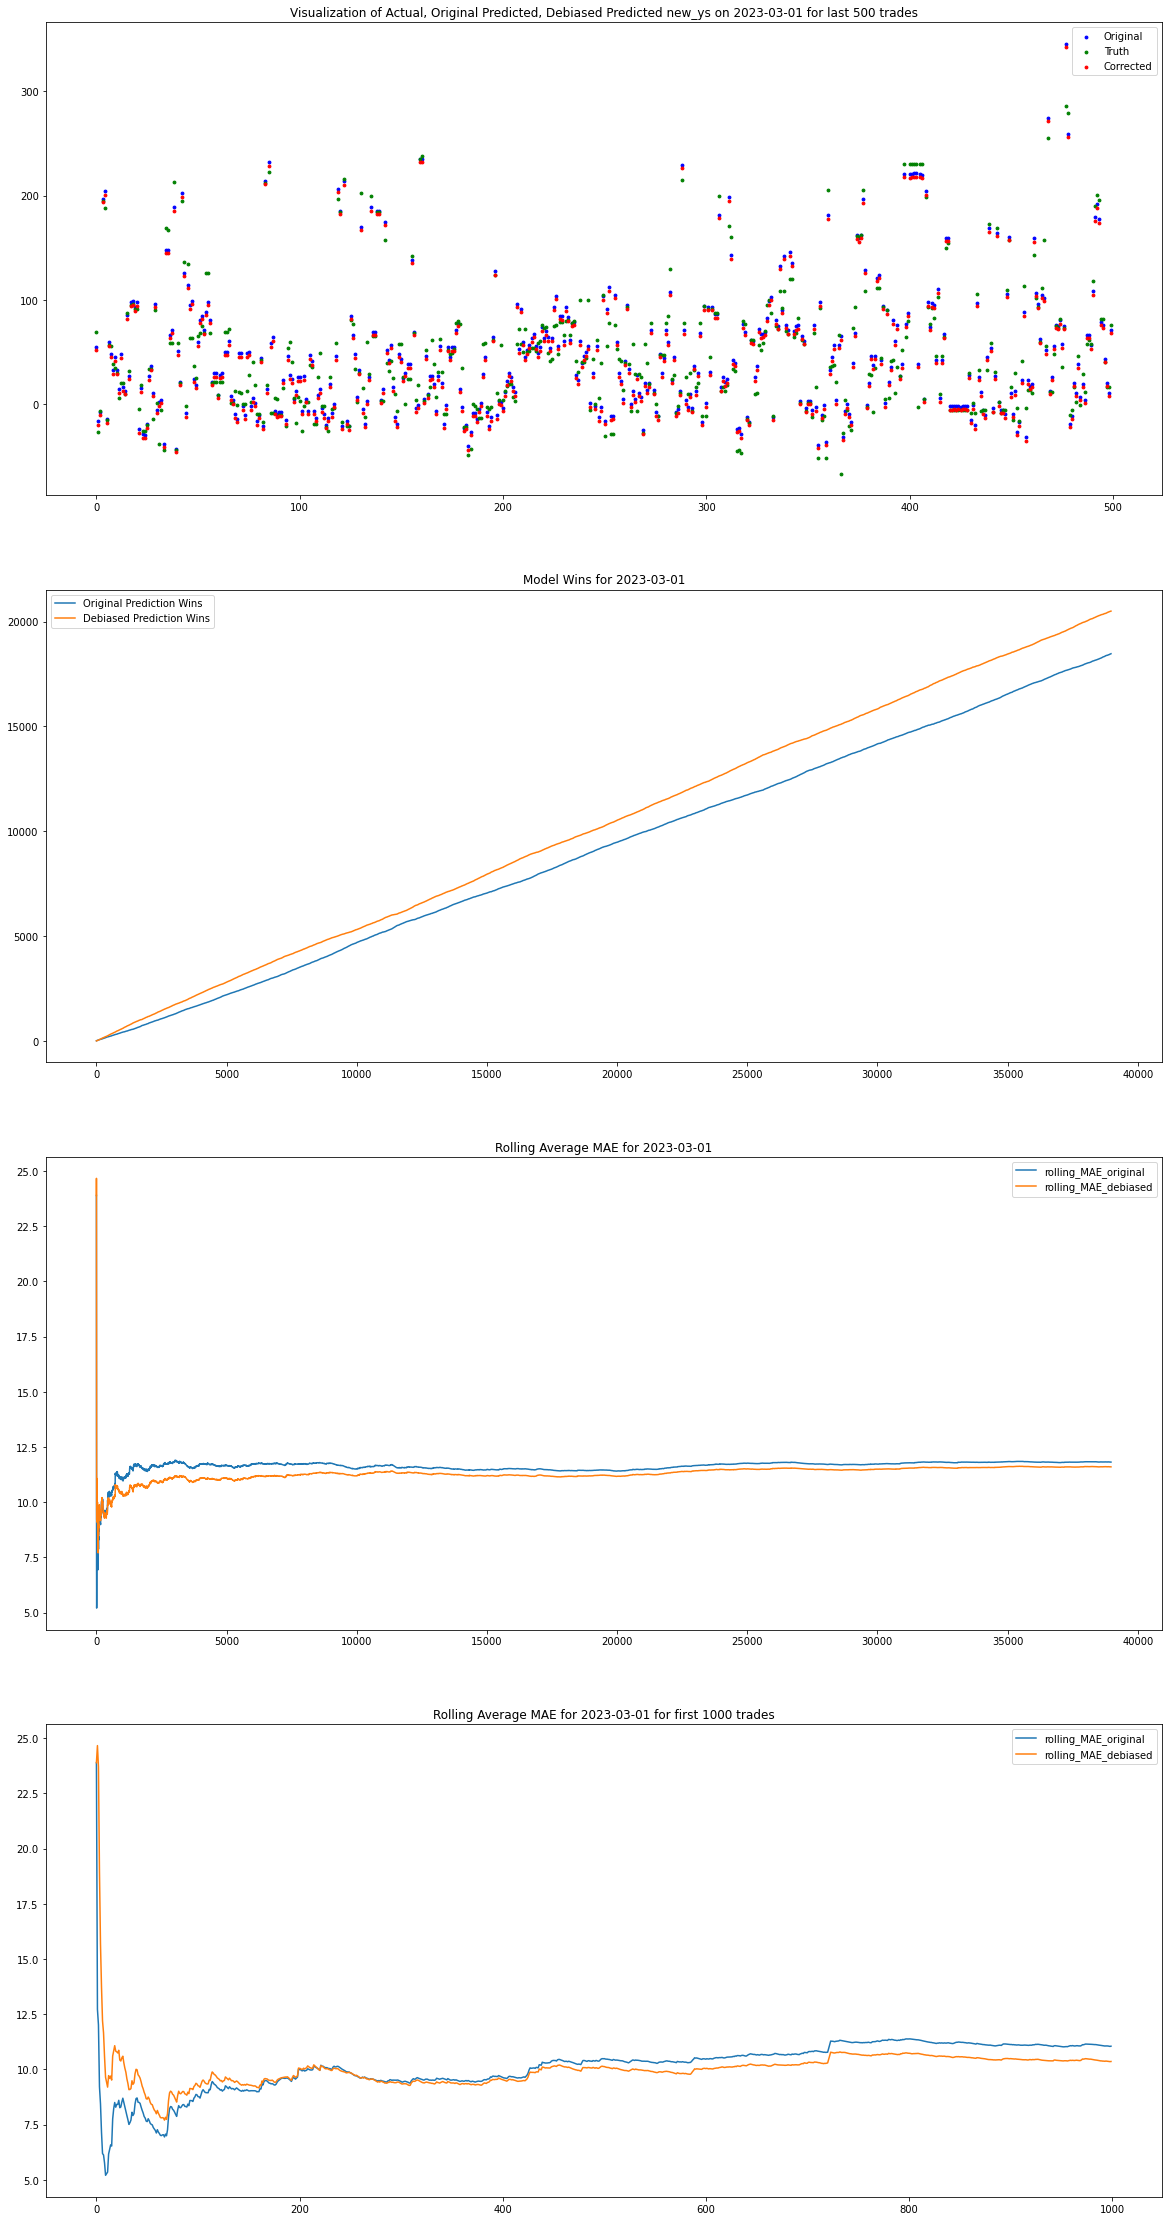

In [43]:
_ = analyze_debiasing_day('2023-03-01', test_dataframe, test_dataframe_bias_date_default_LGBM.values, first_N_trades=1000, last_N_trades=500, prediction_col='lgbm_prediction')

### Testing Realtime Yield Spread:

In [10]:
# %%time

# train_dataframe_rmval = pd.read_pickle('train_dataframe_rmval_realtime.pkl')
# val_dataframe = pd.read_pickle('val_dataframe_realtime.pkl')
# test_dataframe = pd.read_pickle('test_dataframe_realtime.pkl')

In [14]:
test_dataframe['error_realtime'] = test_dataframe['prediction_realtime'] - test_dataframe['new_ys_realtime']

In [16]:
%time test_dataframe_rt_bias_default = test_dataframe.groupby('trade_date')['error_realtime'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))
%time test_dataframe_rt_bias_windowed_default = test_dataframe.groupby('trade_date')['error_realtime'].rolling(2000, min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))

CPU times: user 1min 5s, sys: 4.44 ms, total: 1min 5s
Wall time: 1min 5s
CPU times: user 50.1 s, sys: 4.37 ms, total: 50.1 s
Wall time: 50.1 s


In [17]:
debias_series(test_dataframe.prediction_realtime, test_dataframe.new_ys_realtime, test_dataframe_rt_bias_default.values)
debias_series(test_dataframe.prediction_realtime, test_dataframe.new_ys_realtime, test_dataframe_rt_bias_windowed_default.values)

Original bias: -1.059, Original MAE: 9.335, Corrected bias: -0.080, Corrected MAE: 9.063
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.000, Corrected MAE: 9.053


### Testing a team member's Predictions: 

In [30]:
ahmad_df = pd.read_pickle('prediction.pkl')

In [31]:
len(ahmad_df)

584929

In [32]:
ahmad_df.trade_date.min(), ahmad_df.trade_date.max()

(Timestamp('2023-04-03 00:00:00'), Timestamp('2023-04-28 00:00:00'))

In [33]:
ahmad_df['error'] = ahmad_df['predicted_ytw']  - ahmad_df['yield'] 

In [34]:
ahmad_df[['yield', 'predicted_ytw','absolute_delta']].head(5)

,yield,predicted_ytw,absolute_delta
40569,400.200,409.537,9.337
40570,427.100,426.498,0.602
40578,325.800,340.679,14.879
40579,401.200,402.293,1.093
40580,398.700,399.652,0.952


In [37]:
%time ahmad_df_bias_default = ahmad_df.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default'))

CPU times: user 58.3 s, sys: 0 ns, total: 58.3 s
Wall time: 58.3 s


In [94]:
%time ahmad_df_bias_default = ahmad_df.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='reciprocal'))
%time ahmad_df_bias_default = ahmad_df.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log'))
%time ahmad_df_bias_default = ahmad_df.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='log_reciprocal'))
%time ahmad_df_bias_default = ahmad_df.groupby('trade_date')['error'].expanding(min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='mask_large', mask_large = 35))

CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min 2s
CPU times: user 4min 32s, sys: 0 ns, total: 4min 32s
Wall time: 4min 32s
CPU times: user 4min 34s, sys: 0 ns, total: 4min 34s
Wall time: 4min 35s
CPU times: user 1min 24s, sys: 0 ns, total: 1min 24s
Wall time: 1min 24s


In [77]:
%%time
group_expanding_dataframes = list(ahmad_df.groupby('trade_date')[['error','quantity']].expanding(min_periods=1, method='table'))
ahmad_df_bias_quantity_weighted = []
for sub_df in group_expanding_dataframes:
    ahmad_df_bias_quantity_weighted.append(expanding_weighted_average_test(sub_df, 'quantity'))

CPU times: user 1min 56s, sys: 43.7 ms, total: 1min 56s
Wall time: 1min 56s


In [65]:
analyze_debiasing_MAE(ahmad_df, ahmad_df_bias_default.values, target_col = 'yield', prediction_col ='predicted_ytw')

,Original MAE,Corrected MAE,Corrected - Original MAE
trade_date,,,
2023-04-28,8.152,8.090,-0.062
2023-04-27,7.600,7.596,-0.004
2023-04-26,7.674,7.632,-0.042
2023-04-25,7.924,8.094,0.170
2023-04-24,8.305,8.545,0.239
2023-04-21,7.794,7.925,0.130
2023-04-20,7.418,7.934,0.516
2023-04-19,7.429,8.132,0.703
2023-04-18,7.644,8.655,1.011


In [72]:
ahmad_df['debiased_predicted_ytw'] = ahmad_df['predicted_ytw'] -  ahmad_df_bias_default.values
ahmad_df['debiased_error'] = ahmad_df['debiased_predicted_ytw'] - ahmad_df['yield']
ahmad_df['error'] = ahmad_df['predicted_ytw'] - ahmad_df['yield']

<AxesSubplot:xlabel='yield', ylabel='debiased_predicted_ytw'>

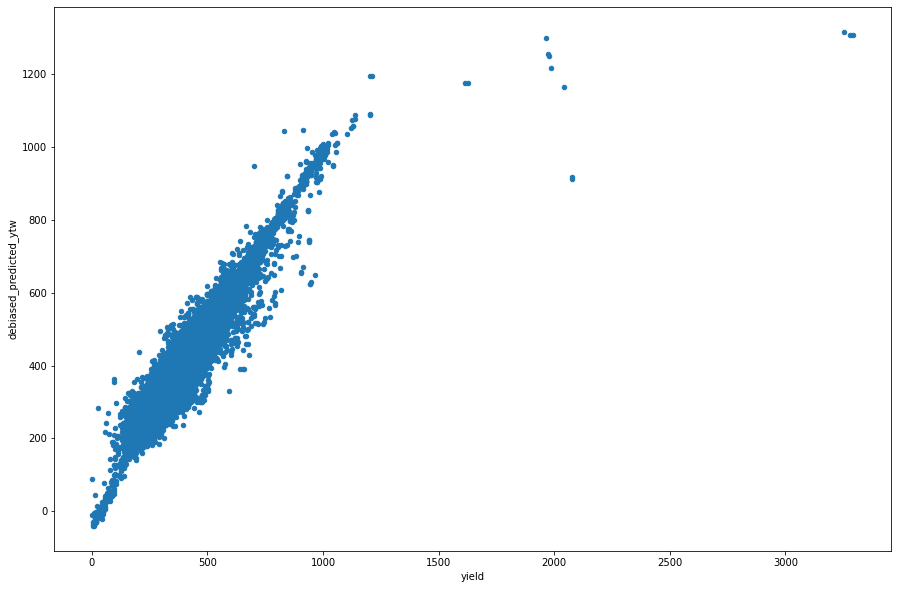

In [75]:
ahmad_df.plot('yield', 'debiased_predicted_ytw', kind='scatter', figsize=(15, 10))

<AxesSubplot:xlabel='yield', ylabel='predicted_ytw'>

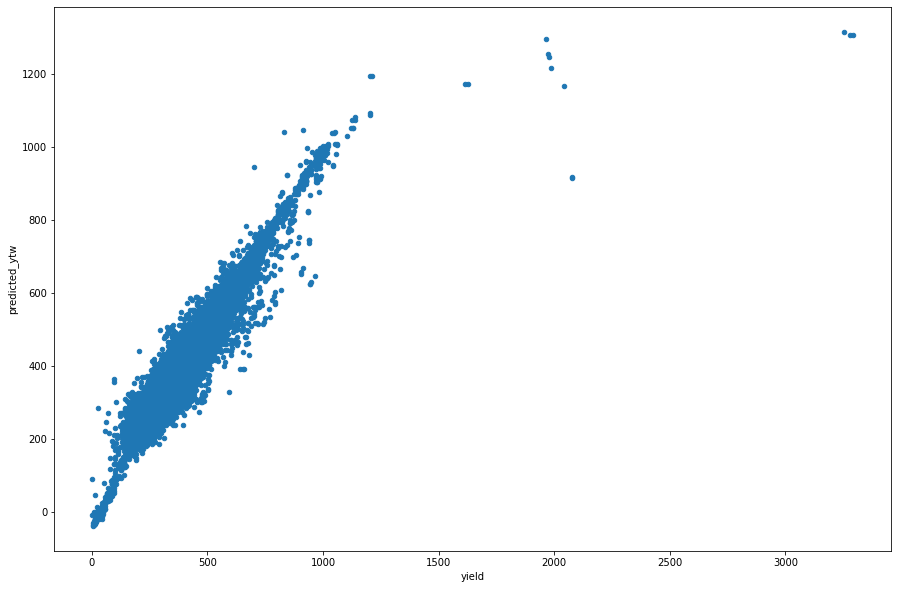

In [74]:
ahmad_df.plot('yield', 'predicted_ytw', kind='scatter', figsize=(15, 10))

<AxesSubplot:xlabel='debiased_predicted_ytw', ylabel='predicted_ytw'>

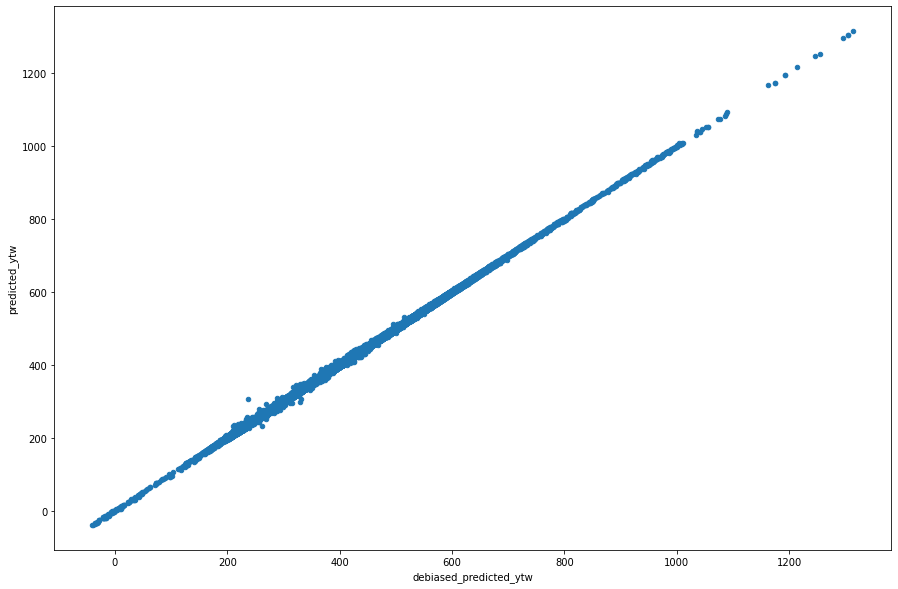

In [91]:
ahmad_df.plot('debiased_predicted_ytw', 'predicted_ytw', kind='scatter', figsize=(15, 10))

### Testing different window sizes:

Default Procedure:

In [111]:
test_dataframe_bias_date_default_windowed = [] 
window_sizes = [200, 500, 1000, 2000, 5000, 10000, 20000]
for window_size in window_sizes:
    %time test_dataframe_bias_date_default_windowed.append(test_dataframe.groupby(['trade_date'])['error'].rolling(window_size, min_periods=1).apply(lambda x: expanding_weighted_average_simple(x, method='default')))

CPU times: user 47.7 s, sys: 0 ns, total: 47.7 s
Wall time: 47.8 s
CPU times: user 48.3 s, sys: 5.96 ms, total: 48.3 s
Wall time: 48.4 s
CPU times: user 45.3 s, sys: 15 ms, total: 45.4 s
Wall time: 45.3 s
CPU times: user 50.8 s, sys: 14.9 ms, total: 50.8 s
Wall time: 50.8 s
CPU times: user 54 s, sys: 18.9 ms, total: 54 s
Wall time: 54.1 s
CPU times: user 57.6 s, sys: 27 ms, total: 57.6 s
Wall time: 57.6 s
CPU times: user 1min 3s, sys: 18.6 ms, total: 1min 3s
Wall time: 1min 3s


In [79]:
debias_series(test_dataframe.prediction, test_dataframe.new_ys, test_dataframe_bias_default.values)
for i, bias in enumerate(test_dataframe_bias_date_default_windowed): 
    debias_series(test_dataframe.prediction, test_dataframe.new_ys, bias.values)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.114, Corrected MAE: 9.056
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.008, Corrected MAE: 9.067
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.014, Corrected MAE: 9.051
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.020, Corrected MAE: 9.049
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.032, Corrected MAE: 9.049
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.064, Corrected MAE: 9.051
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.114, Corrected MAE: 9.056


Quantity Weighted Average

In [88]:
%%time
window_sizes = [200, 500, 1000, 2000, 5000, 10000, 20000]
test_dataframe_bias_quantity_weighted_windowed = []

for window_size in window_sizes:
    temp = []
    group_expanding_dataframes = list(test_dataframe.groupby('trade_date')[['error','quantity']].rolling(window_size, min_periods=1, method='table'))
    for sub_df in group_expanding_dataframes:
        temp.append(expanding_weighted_average_test(sub_df, 'quantity'))
    test_dataframe_bias_quantity_weighted_windowed.append(temp)

CPU times: user 14min 3s, sys: 939 ms, total: 14min 4s
Wall time: 14min 4s


In [109]:
for i, bias in enumerate(test_dataframe_bias_quantity_weighted_windowed): 
    debias_series(test_dataframe.prediction, test_dataframe.new_ys, bias)

Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.016, Corrected MAE: 9.101
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.013, Corrected MAE: 9.063
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.009, Corrected MAE: 9.047
Original bias: -1.576, Original MAE: 9.337, Corrected bias: -0.004, Corrected MAE: 9.047
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.009, Corrected MAE: 9.046
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.039, Corrected MAE: 9.049
Original bias: -1.576, Original MAE: 9.337, Corrected bias: 0.079, Corrected MAE: 9.054


In [ ]:
def plot_windowed_bias_comparison(window_sizes, df, biases):
    windowed_biases = pd.DataFrame(columns=window_sizes, index=test_dataframe.trade_datetime)
    for i, col in enumerate(window_sizes):
        windowed_biases[col] = test_dataframe_bias_date_default_windowed[i]
    target_date = '2023-03-01'
    fig, ax = plt.subplots(figsize=(15, 12))
    windowed_biases.loc[target_date][[1000, 2000, 5000, 10000, 20000]].reset_index(drop='True').plot(ax=ax)
    ax.legend()

In [220]:
# windowed_biases = pd.DataFrame(columns=window_sizes, index=test_dataframe.trade_datetime)
# for i, col in enumerate(window_sizes):
#     windowed_biases[col] = test_dataframe_bias_date_default_windowed[i]

In [221]:
# target_date = '2023-03-01'
# fig, ax = plt.subplots(figsize=(15, 12))
# windowed_biases.loc[target_date][[1000, 2000, 5000, 10000, 20000]].reset_index(drop='True').plot(ax=ax)
# ax.legend()

## Simulating debiasing with full exclusions based on published datetime

**Masking Recent Trades**<br>
To properly simulate how debiasing will be applied in production, we need to account for the fact that we don't have all the trades preceding a given trade, at least by 60 seconds. To simulate this in testing, we mask trades within 60 seconds of a trade based on the difference between a given trade's trade_datetime and the first_published_datetime of preceding trades. There is little change in the results (MAE improvements are reduced by 0.05).

This suggests that the bulk of data drift between model training data and out-of-sample data is consistent throughout the day - hence with sufficient observations within the day, we can adequately correct for model biases even if we don't have the most recent trades. 

As a side note, the need to mask every sub-dataframe generated by pd.groupby().rolling() is computationally expensive. Since calculations are unique to each sub-dataframe (which is based on each trade), these masks cannot be calculated beforehand. Processing time increases from ~2mins to ~15mins. 

**Warm Start**<br>
We also test the concept of warm starts here, and the result is as expected: negliglbe. Since the improvement to MAE begins to manifest ~50 trades into the day (see the graphs above for MAE through the first 500 trades of a day), the benefit of a warm start on the overall performance is imperceptible. However it is still beneficial since it does help to avoid spikes in the MAE at the start of the day, at least to an extent that is worse than the original predictions.

In [63]:
test_dataframe.sort_values('first_published_datetime', inplace=True, ascending=True)
test_dataframe.reset_index(drop=True, inplace=True)

In [113]:
%time test_dataframe_rt_bias_default = simulate_weighted_average(test_dataframe, 'error_realtime', 'error_realtime', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'default')

CPU times: user 1min 28s, sys: 46.1 ms, total: 1min 28s
Wall time: 1min 28s


In [117]:
%time test_dataframe_rt_bias_default_masked = simulate_weighted_average_masked(test_dataframe, 'error_realtime', 'error_realtime', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'default')

CPU times: user 14min 54s, sys: 146 ms, total: 14min 55s
Wall time: 14min 56s


In [118]:
%time test_dataframe_rt_bias_simple = simulate_weighted_average(test_dataframe, 'error_realtime', 'error_realtime', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'simple_average')
%time test_dataframe_rt_bias_simple_masked = simulate_weighted_average_masked(test_dataframe, 'error_realtime', 'error_realtime', groupby_cols = ['trade_date'], window_size = 2000, weighting_method = 'simple_average')

CPU times: user 1min 31s, sys: 11.9 ms, total: 1min 31s
Wall time: 1min 31s
CPU times: user 14min 58s, sys: 179 ms, total: 14min 58s
Wall time: 14min 59s


In [215]:
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], test_dataframe_rt_bias_simple)
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], test_dataframe_rt_bias_simple_masked)
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], bias_warm_start(test_dataframe_rt_bias_simple, test_dataframe, 50))
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], bias_warm_start(test_dataframe_rt_bias_simple_masked,  test_dataframe, 50))
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], bias_warm_start(test_dataframe_rt_bias_simple, test_dataframe, 200))
debias_series(test_dataframe['prediction_realtime'], test_dataframe['new_ys_realtime'], bias_warm_start(test_dataframe_rt_bias_simple_masked,  test_dataframe, 200))

Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.023, Corrected MAE: 9.057
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.022, Corrected MAE: 9.062
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.021, Corrected MAE: 9.057
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.020, Corrected MAE: 9.062
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.009, Corrected MAE: 9.057
Original bias: -1.059, Original MAE: 9.335, Corrected bias: 0.008, Corrected MAE: 9.062


In [126]:
pd.merge(analyze_debiasing_MAE(test_dataframe, test_dataframe_rt_bias_simple, prediction_col = 'prediction_realtime', target_col='new_ys_realtime')['Corrected MAE'],
         analyze_debiasing_MAE(test_dataframe, test_dataframe_rt_bias_simple_masked, prediction_col = 'prediction_realtime', target_col='new_ys_realtime')['Corrected MAE'],
        left_index=True,
        right_index=True)

,Corrected MAE_x,Corrected MAE_y
trade_date,,
2023-03-01,8.501,8.510
2023-03-02,8.338,8.340
2023-03-03,8.557,8.566
2023-03-06,8.641,8.644
2023-03-07,8.769,8.772
2023-03-08,8.693,8.694
2023-03-09,8.742,8.747
2023-03-10,8.963,8.970
2023-03-13,9.334,9.339


OVERALL ORIGINAL MAE: 8.88, OVERALL DEBIASED MAE: 8.51


,trade_datetime,prediction_realtime,new_ys_realtime,bias_correction,debiased_prediction,original_error,debiased_error
trade_date,,,,,,,
2023-03-01,2023-03-01 00:04:00,194.658,186.162,0.000,194.658,-8.497,-8.497
2023-03-01,2023-03-01 07:09:00,5.845,9.523,8.497,-2.651,3.678,12.174
2023-03-01,2023-03-01 07:09:24,2.470,12.406,8.497,-6.027,9.936,18.433
2023-03-01,2023-03-01 07:09:24,11.016,12.406,8.497,2.520,1.390,9.886
2023-03-01,2023-03-01 07:11:01,6.034,10.124,-1.627,7.661,4.090,2.464
...,...,...,...,...,...,...,...
2023-03-01,2023-03-01 18:17:12,79.426,77.802,1.773,77.653,-1.624,0.149
2023-03-01,2023-03-01 18:21:39,43.302,37.246,-4.185,47.487,-6.055,-10.241
2023-03-01,2023-03-01 18:45:48,12.616,11.393,1.782,10.834,-1.223,0.559


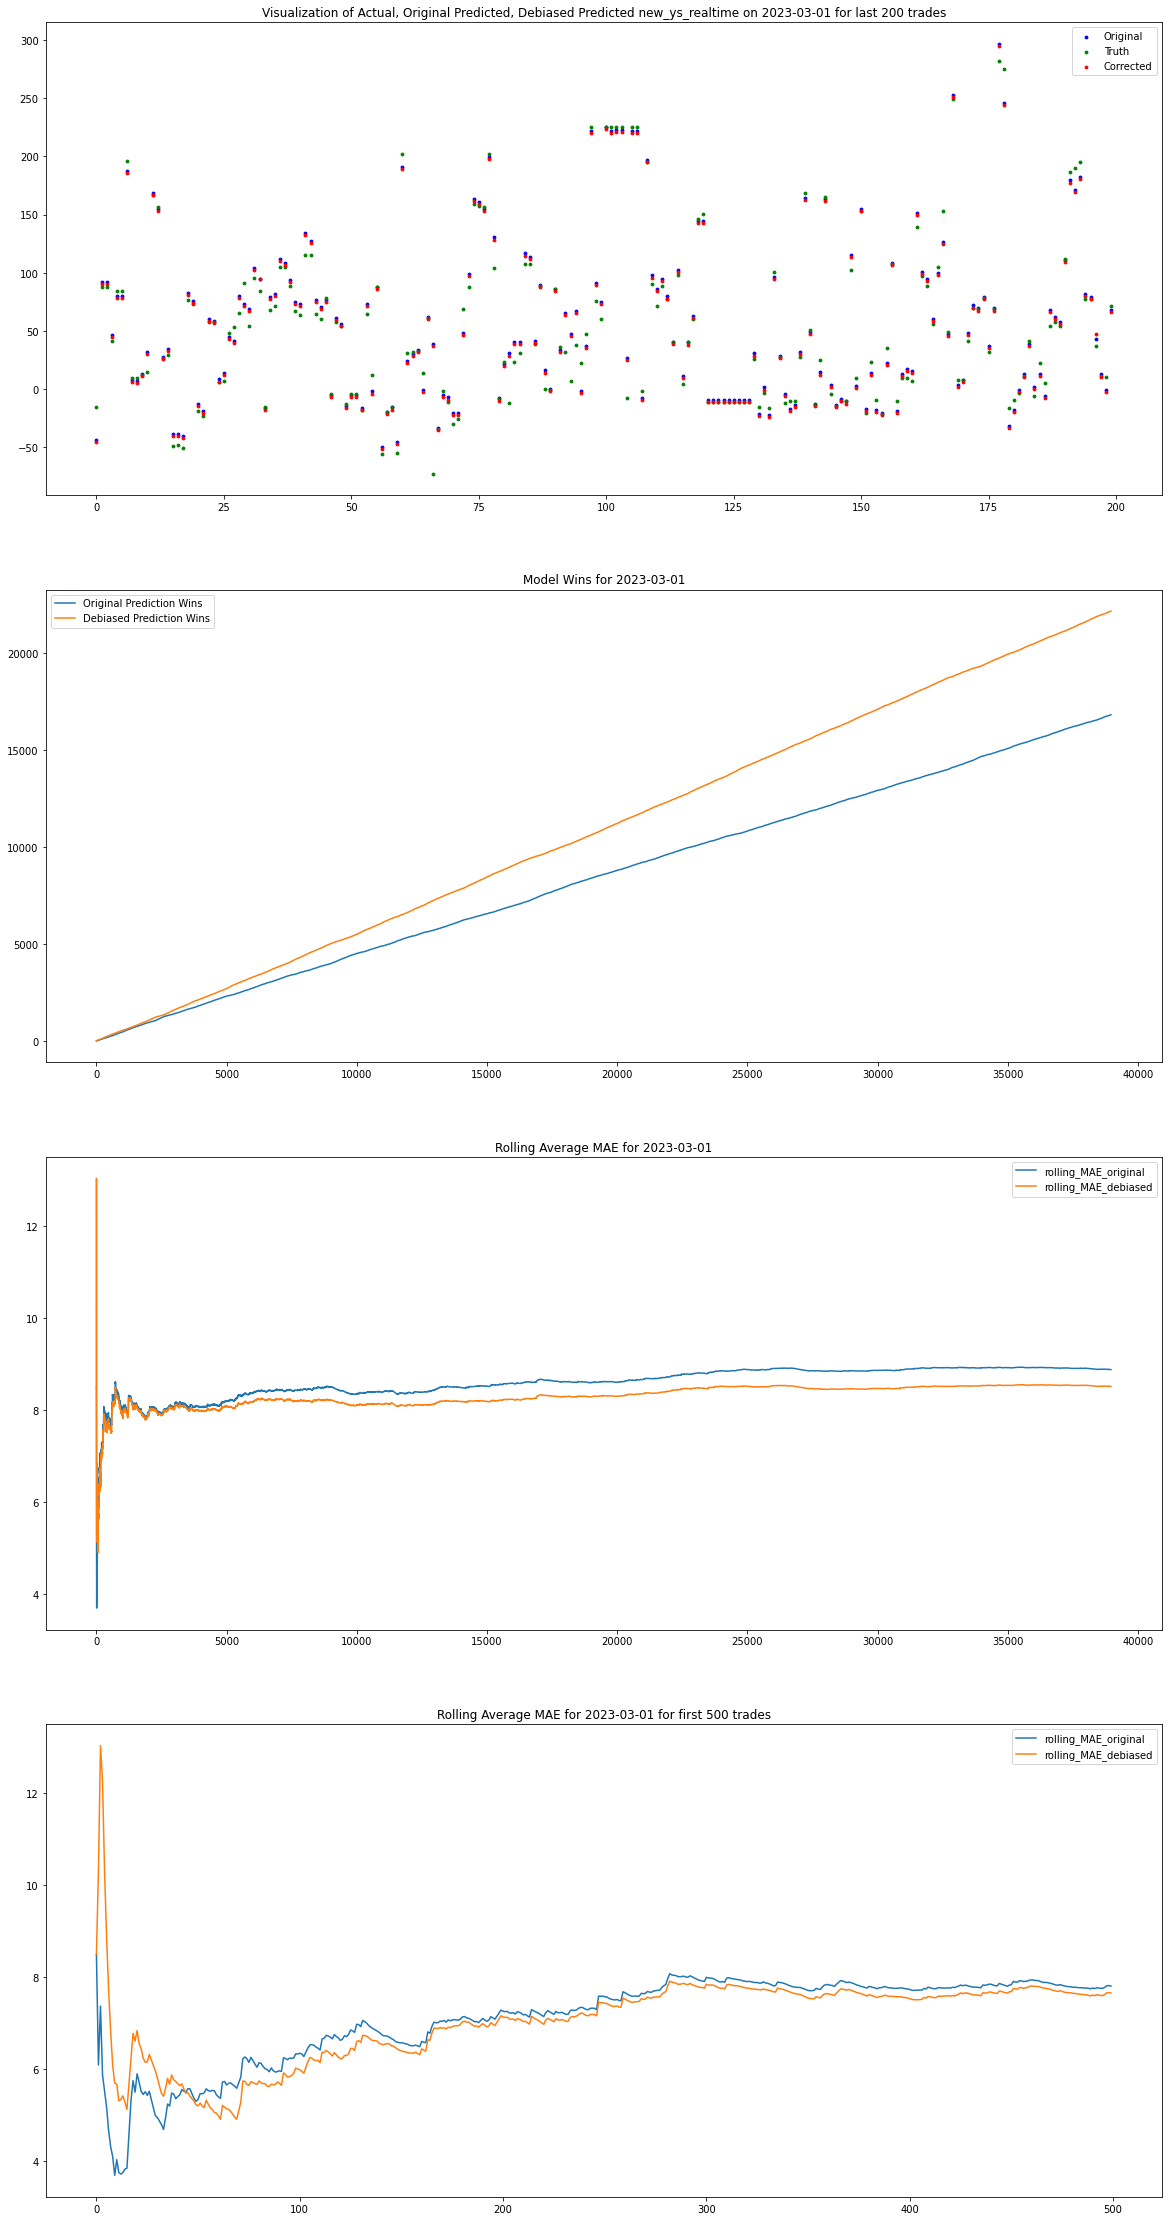

In [130]:
analyze_debiasing_day('2023-03-01', test_dataframe, test_dataframe_rt_bias_simple_masked, prediction_col = 'prediction_realtime', target_col='new_ys_realtime')

OVERALL ORIGINAL MAE: 8.88, OVERALL DEBIASED MAE: 8.51


,trade_datetime,prediction_realtime,new_ys_realtime,bias_correction,debiased_prediction,original_error,debiased_error
trade_date,,,,,,,
2023-03-01,2023-03-01 00:04:00,194.658,186.162,0.000,194.658,-8.497,-8.497
2023-03-01,2023-03-01 07:09:00,5.845,9.523,0.000,5.845,3.678,3.678
2023-03-01,2023-03-01 07:09:24,2.470,12.406,0.000,2.470,9.936,9.936
2023-03-01,2023-03-01 07:09:24,11.016,12.406,0.000,11.016,1.390,1.390
2023-03-01,2023-03-01 07:11:01,6.034,10.124,0.000,6.034,4.090,4.090
...,...,...,...,...,...,...,...
2023-03-01,2023-03-01 18:17:12,79.426,77.802,1.773,77.653,-1.624,0.149
2023-03-01,2023-03-01 18:21:39,43.302,37.246,-4.185,47.487,-6.055,-10.241
2023-03-01,2023-03-01 18:45:48,12.616,11.393,1.782,10.834,-1.223,0.559


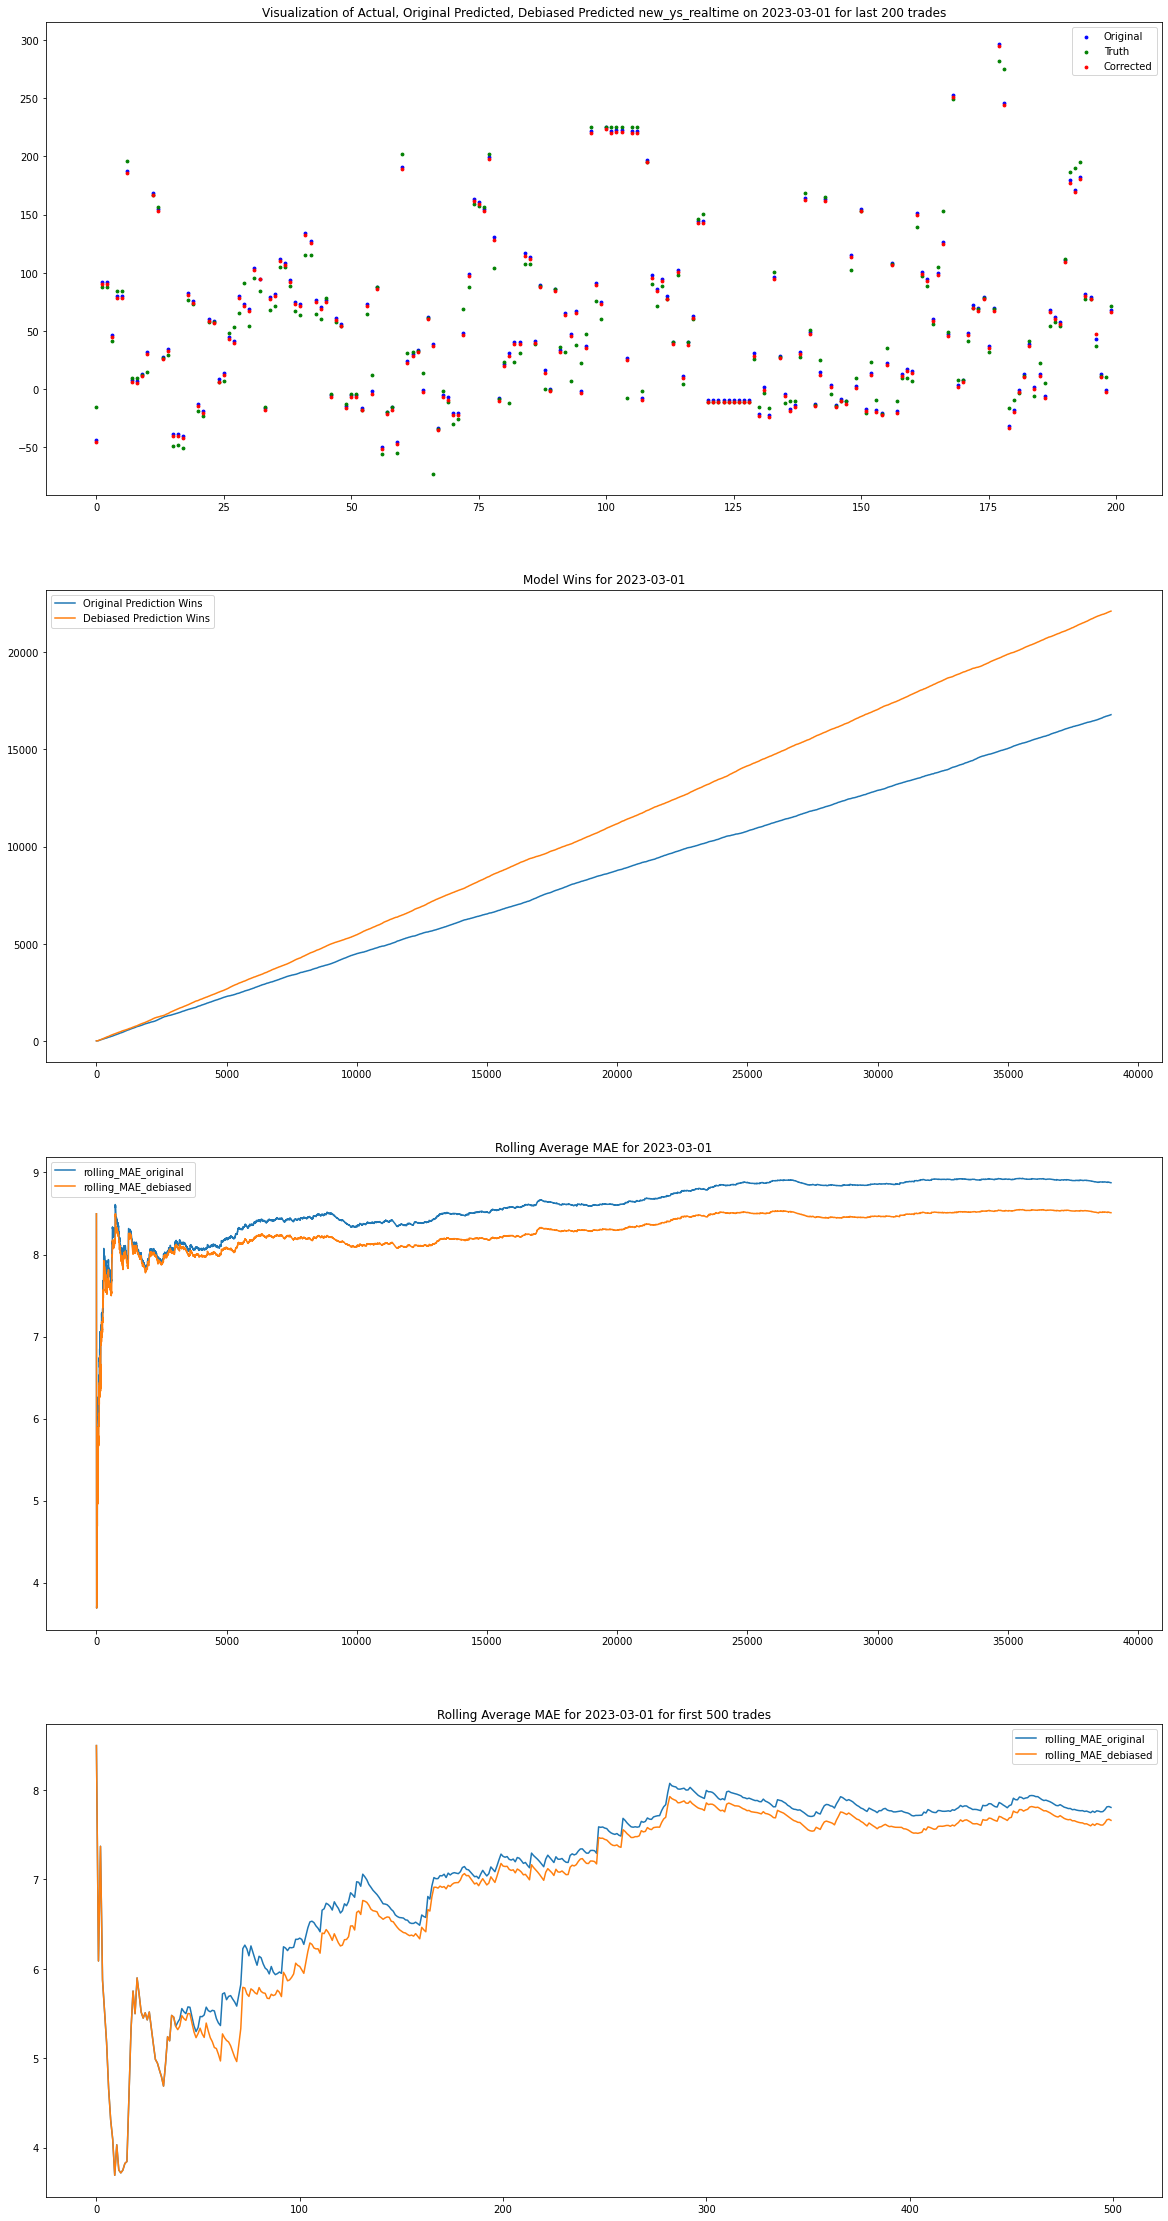

In [216]:
analyze_debiasing_day('2023-03-01', test_dataframe, 
                      bias_warm_start(test_dataframe_rt_bias_simple_masked,  test_dataframe, 50), 
                      prediction_col = 'prediction_realtime', 
                      target_col='new_ys_realtime')

OVERALL ORIGINAL MAE: 8.88, OVERALL DEBIASED MAE: 8.50


,trade_datetime,prediction_realtime,new_ys_realtime,bias_correction,debiased_prediction,original_error,debiased_error
trade_date,,,,,,,
2023-03-01,2023-03-01 00:04:00,194.658,186.162,0.000,194.658,-8.497,-8.497
2023-03-01,2023-03-01 07:09:00,5.845,9.523,-0.943,6.788,3.678,2.735
2023-03-01,2023-03-01 07:09:24,2.470,12.406,8.497,-6.027,9.936,18.433
2023-03-01,2023-03-01 07:09:24,11.016,12.406,-0.720,11.736,1.390,0.670
2023-03-01,2023-03-01 07:11:01,6.034,10.124,-1.627,7.661,4.090,2.464
...,...,...,...,...,...,...,...
2023-03-01,2023-03-01 18:17:12,79.426,77.802,1.774,77.652,-1.624,0.150
2023-03-01,2023-03-01 18:21:39,43.302,37.246,-4.440,47.741,-6.055,-10.495
2023-03-01,2023-03-01 18:45:48,12.616,11.393,1.782,10.834,-1.223,0.559


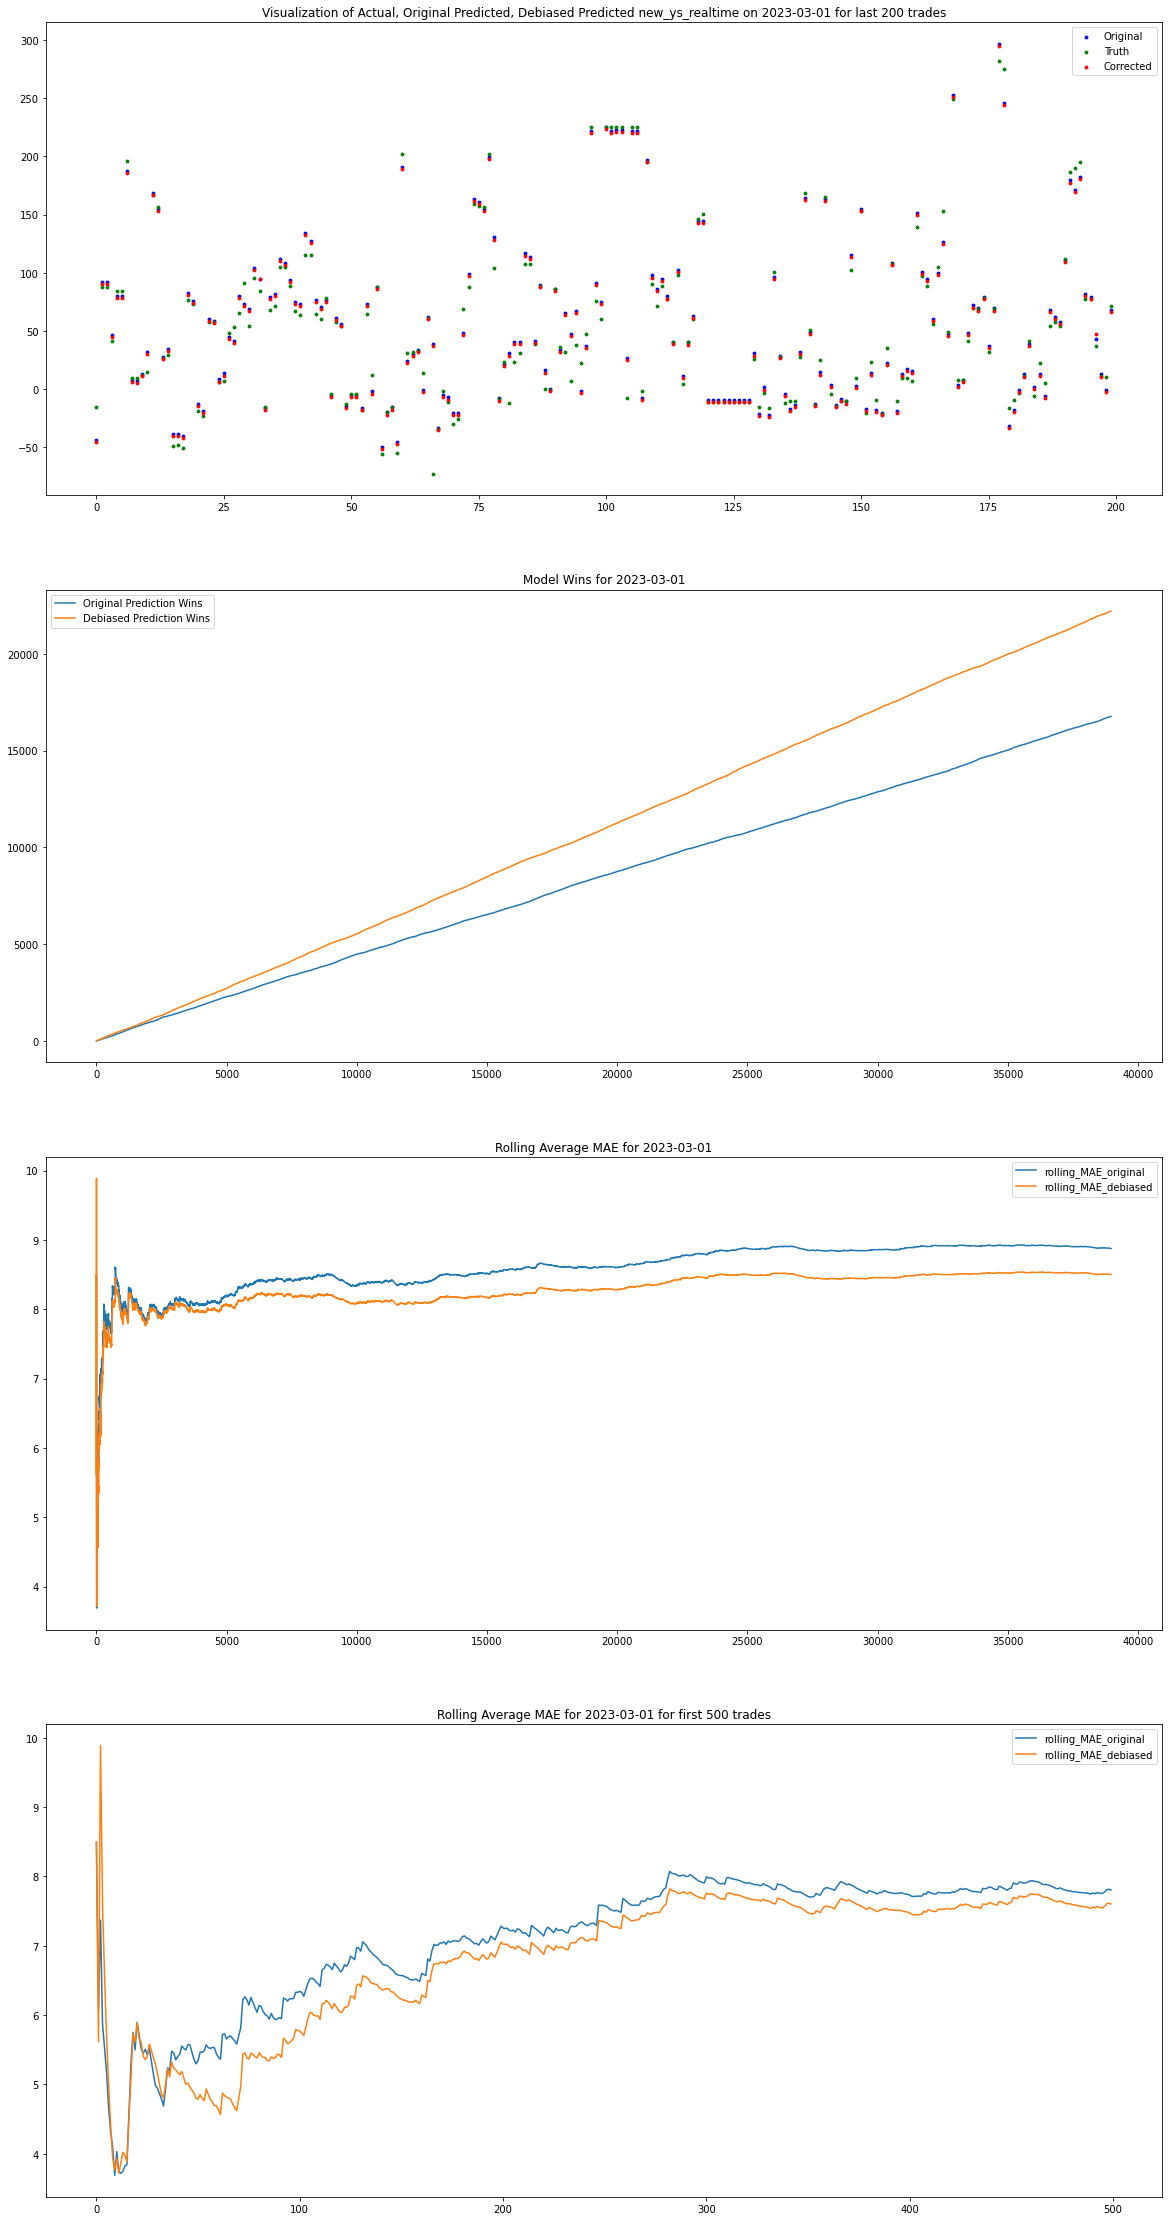

In [129]:
analyze_debiasing_day('2023-03-01', 
                      test_dataframe, 
                      test_dataframe_rt_bias_simple, 
                      prediction_col = 'prediction_realtime', 
                      target_col='new_ys_realtime')